# Creating different geodynamical experiments:

This notebook aims to create different examples of geodymanical experiments as:

- Lithosphere Asthenosphere Boundary (LAB) stability over time

- Wilson cycle - Accordion

- Continental rifting

By choosing one of the experiments above, the following script will automatically create the correct interfaces and boundary conditions to simulate each geodynamic experiment above.

We also implement some strategies to use the final thermal state from a given previous stability experiment as initial temperature field for Wilson Cycle experiments.

The domain of the model comprises 1600 x 700 km<sup>2</sup>, composed of a regular mesh with square elements of 4 x 4 km<sup>2</sup>. However, the user can modify those values to simulate scenarios with higher resolutions
For Wilson cycle and continental rifting experiments, the boundary conditions for the velocity field simulate the lithospheric stretching 
assuming a reference frame fixed on the lithospheric plate on the left side of the model,
and the plate on the right side moves rightward with a velocity of 1 cm/year.
The velocity field in the left and right boundaries of the model is chosen to ensure conservation of mass
and is symmetrical if the adopted reference frame movies to the right with a velocity of 0.5 cm/year relative to the left plate.
Additionally, free slip condition was assumed on the top and bottom of the numerical domain.
To simulate the free surface, the "sticky air" approach (e.g. Gerya and Yuen, 2003b) is adopted,
taking into account a 40-km thick layer with a relatively low viscosity material but with a compatible density with the atmospheric air.
The initial temperature structure is only depth dependent and is 0 ºC at the surface and 1300 ºC at the base of the lithosphere at 130 km.

To avoid artifacts created by a homogeneous rheology, a random perturbation of the initial strain in each finite element of the model (e.g. Brune et al., 2014) is applied.
This random perturbation follows a normal distribution in which the mean initial strain is 0.25 with a standard deviation of 0.08.
Additionally, to ensure the nucleation of rifting at the center of the numerical domain,
a weak seed (e.g. Huismans and Beaumont, 2003) is present in the lithospheric mantle with a constant initial strain of 0.3.


Brune S., Heine C., Pérez-Gussinyé M., Sobolev S. V., Rift migration explains continental margin asymmetry and crustal hyper-extension,
Nature communications, 2014, vol. 5, p. 1.

Gerya T. V., Yuen D. A., Characteristics-based marker-in-cell method with conservative finite-differences schemes for modeling geological flows with strongly variable transport properties, Physics of the Earth and Planetary Interiors, 2003a, vol. 140, p. 293

Huismans R. S., Beaumont C., Symmetric and asymmetric lithospheric extension: Relative effects of frictional-plastic and viscous strain softening, Journal of Geophysical Research: Solid Earth, 2003, vol. 108

# Generate input files

In [1]:
import os
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

label_size=18
plt.rc('xtick', labelsize=label_size)
plt.rc('ytick', labelsize=label_size)

#FUNCITIONS
def find_nearest(array, value):
    '''Return the index in array nearest to a given value.
    
    Parameters
    ----------
    
    array: array_like
        1D array used to find the index
        
    value: float
        Value to be seached
    '''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def read_params(fpath):
    '''
    Read param.txt and returns Nx, Nz, Lx, Lz of the scenario givem by fpath
    
    Parameters
    ----------
    
    fpath: str
        Path to the param.txt file
    '''
    with open(fpath+"param.txt","r") as f:
        line = f.readline()
        line = line.split() #split by space a string to a list of strings
        Nx = int(line[-1])
        
        line = f.readline()
        line = line.split()
        Nz = int(line[-1])

        line = f.readline()
        line = line.split()
        Lx = float(line[-1])

        line = f.readline()
        line = line.split()
        Lz = float(line[-1])

    return Nx, Nz, Lx, Lz

def read_data(prop, step, Nz, Nx, fpath):
    '''
    Read and reshape readed data according to parameters to return a (Nx, Nz) array.
    
    Parameters
    ----------
    
    prop: str
        Property of the mandyoc outputs: temperature, density, strain, strain_rate, viscosity, heat or pressure.
        
    step: str
        Time step of numerical scenario.
        
    Nz: int
        Number of points in z direction.
        
    Nx: int
        Number of points in x direction.
        
    fpath: str
        Path to the param.txt file.
    '''
    
    #build filename
    filename = fpath + prop + "_" + str(step) + ".txt"

    data = np.loadtxt(filename, skiprows=2, unpack=True, comments="P")
    data = np.reshape(data, (Nz, Nx))
    
    return data

def calc_mean_temperaure_region(data, Nz, xx, begin, end):
    '''
    This funcition select a region in x direction in a 2D array and calculates the horizontal mean

    Parameters
    ----------

    data: `numpy.ndarray`

    Nz: int
        Number of points in Z direction

    xx: numpy.ndarray
        2D grid with x cordinates

    begin: float
        Start point

    end: float
        End point

    Returns
    -------
    arr: `numpy.ndarray`
        Array containing the horizontal mean of selected region
    '''

    x_region = (xx >= begin) & (xx <= end)
    Nx_aux = len(x_region[0][x_region[0]==True])
    data_sel = data[x_region].reshape(Nz, Nx_aux)
    data_sel_mean = np.mean(data_sel, axis=1)
    
    return data_sel_mean

def Tp_estimate(mean_temp, z, zbot, ztop, h_air=40.0e3):
    zcond = (z<=zbot-h_air) & (z>=ztop-h_air) #considering air layer

    zcut = z[zcond]
    tcut = mean_temp[zcond]

    params = curve_fit(fit_func, zcut, tcut)
    [a, b] = params[0]

    tfit = a*z + b #temeprature fitted

    #find the mantle potential temperature
    idx = np.where(z == 40.0)[0][0] #air thickness = 40 
    Tp = int(np.round(tfit[idx], 0))

    return Tp, tfit

def fit_func(x, a, b):
    return a*x + b

# System path

Identifying operational system (Linux or MacOSX)

In [2]:
path = os.getcwd().split('/')
machine_path = f'/{path[1]}/{path[2]}'
print(machine_path)

/Users/joao_macedo


# The code cell bellow will:

## Colect the important scenario information

We will construct a list called `scenario_infos` to create a .txt file containing the most import information about the numerical experiment as:
- Experiment: type of geodynamic experiment
- Viscosity scale factors (C) of the layers
- Domain parameters
- Layers thickness

## Define the type of the geodynamic experiment

Here we have six types of geodynamic experiments. You must choose between:

- `'stability'`: Lithosphere Asthenosphere Boundary (LAB) stability over time. This experiment aims to be used as Preliminary Experiment following the approach of Petersen et al. (2010) to achieve a dynamic equilibrium state.
- `'rifting'`: Rifting experiment like Silva et al. (2023)
-`'wilson_cycle'`: Wilson cycle experiment starting from rifting to collision.
- `'cratonic_keel'`: Evolution of a central cratonic keel over time based on Silva et al. (2025)


Select by ncommenting one of the `experiment` options in the cell below

## Setup the numerical scenario according to the selected numerical experiment

Some of parameters changes according to the selected type of experiment, e.g.:
- Viscosity scale factor of the layers
- Layer thickness
- Number of layers
- Temperature boundary conditions
- Velocity boundary conditions

Therefore, for each conditional (`if(experiment == <type_of_experiment>)`) below, we set the main parameters of the respective experiment.

#### Create the interface file

The interface file contain the layer properties and the interface's depth between these layers. 

Layer properties:
* Compositional factor (C)
* Density (rho)
* Radiogenic heat (H)
* Pre-exponential scale factor (A)
* Power law exponent (n)
* Activation energy (Q)
* Activation volume (v)

For more information about, please, check de commented lines within the code cell.

In [3]:
# Geodynamic experiments
experiments = {'rifting': 'Rifting experiment',
               'stability': 'LAB (1300 oC) stability',
               'wilson_cycle': 'Wilson Cycle',
               'cratonic_keel': 'Cratonic Keel',
               }
scenario_infos = ['SCENARIO INFOS:']
scenario_infos.append(' ')
scenario_infos.append('Name: ' + path[-1])

#Uncomment one of the lines below to select the the kind of tectonic scenario
# experiment = 'rifting'
# experiment = 'stability'
# experiment = 'wilson_cycle'
experiment = 'cratonic_keel'

ncores=20

print(f'Experiment: {experiments[experiment]}')
scenario_infos.append(f'Experiment: {experiments[experiment]}')

print('N cores: '+str(ncores))
scenario_infos.append('N cores: '+str(ncores))

#Main parameters used to construct param .txt that changes accordind to
#tectonic regime

####################################
#                                  #
#            Stability             #      
# (Used as Preliminary Experiment) #
#                                  #
####################################

if(experiment == 'stability'):
    #######################################################
    # Rheological parameters to build interfaces.txt file #
    #######################################################

    #Viscosity scale factor
    C_ast = 1.0
    C_mlit = 1.0
    C_lower_crust = 10.0
    C_upper_crust = 1.0
    C_air = 1.0

    #density (kg/m3)
    rho_ast = 3378.0
    rho_mlit = 3354.0
    rho_lower_crust = 2800.0
    rho_upper_crust = 2700.0
    rho_air = 1.0

    #radiogenic heat production (W/m3)
    H_ast = 7.38e-12 #Turccote book #original is 0.0
    # H_ast = 10.0e-12
    H_mlit = 9.0e-12
    H_lower_crust = 0.8e-6 / 2800.0 #2.85E-10
    H_upper_crust = 2.5e-6 / 2700.0 #9.259E-10
    H_air = 0.0

    rheology_mlit = 'dry_olivine'
    # rheology_mlit = 'wet_olivine'

    if(rheology_mlit == 'dry_olivine'):
        #pre exponential constant (Pa^-n s^-1)
        A_ast = 1.393e-14 
        A_mlit = 2.4168e-15
        A_lower_crust = 8.574e-28
        A_upper_crust = 8.574e-28
        A_air = 1.0e-18

        #power law exponent
        n_ast = 3.0
        n_mlit = 3.5
        n_lower_crust = 4.0
        n_upper_crust = 4.0
        n_air = 1.0

        #activation energy (J/mol)
        Q_ast = 429.0e3
        Q_mlit = 540.0e3
        Q_lower_crust = 222.0e3
        Q_upper_crust = 222.0e3
        Q_air = 0.0

        #activation volume (m3/mol)
        V_ast = 15.0e-6
        V_mlit = 25.0e-6
        V_lower_crust = 0.0
        V_upper_crust = 0.0
        V_air = 0.0    

    if(rheology_mlit == 'wet_olivine'):
        #pre exponential constant (Pa^-n s^-1)
        A_ast = 1.393e-14 
        A_mlit = 1.393e-14
        A_lower_crust = 8.574e-28
        A_upper_crust = 8.574e-28
        A_air = 1.0e-18

        #power law exponent
        n_ast = 3.0
        n_mlit = 3.0
        n_lower_crust = 4.0
        n_upper_crust = 4.0
        n_air = 1.0

        #activation energy (J/mol)
        Q_ast = 429.0e3
        Q_mlit = 429.0e3
        Q_lower_crust = 222.0e3
        Q_upper_crust = 222.0e3
        Q_air = 0.0

        #activation volume (m3/mol)
        V_ast = 15.0e-6
        V_mlit = 15.0e-6
        V_lower_crust = 0.0
        V_upper_crust = 0.0
        V_air = 0.0

    layer_properties = f"""
                        C   {C_ast}   {C_mlit}   {C_mlit}   {C_lower_crust}   {C_upper_crust}   {C_air}
                        rho {rho_ast} {rho_mlit} {rho_mlit} {rho_lower_crust} {rho_upper_crust} {rho_air}
                        H   {H_ast}   {H_mlit}   {H_mlit}   {H_lower_crust}   {H_upper_crust}   {H_air}
                        A   {A_ast}   {A_mlit}   {A_mlit}   {A_lower_crust}   {A_upper_crust}   {A_air}
                        n   {n_ast}   {n_mlit}   {n_mlit}   {n_lower_crust}   {n_upper_crust}   {n_air}
                        Q   {Q_ast}   {Q_mlit}   {Q_mlit}   {Q_lower_crust}   {Q_upper_crust}   {Q_air}
                        V   {V_ast}   {V_mlit}   {V_mlit}   {V_lower_crust}   {V_upper_crust}   {V_air}
                    """

    # DeltaT = 0
    DeltaT = 200 #oC incrase in initial guess of mantle potential temperature
    # DeltaT = 350

    preset = False
    # keel_center = True

    keel_center = False
    extra_fragil = False

    # keel_adjust = True
    keel_adjust = False

    # high_kappa_in_asthenosphere = True
    high_kappa_in_asthenosphere = False #default
    
    #Convergence criteria
    # denok                            = 1.0e-11
    # denok                            = 1.0e-13
    denok                            = 1.0e-12

    # dt_max = 5.0e3 #default
    dt_max = 2.0e3
    # dt_max = 2.5e3

    particles_per_element            = 100
    
    #Surface constrains
    sp_surface_tracking              = True
    sp_surface_processes             = False
    
    #time constrains  
    time_max                         = 1.0e9 
    step_print                       = 500
    
    #External inputs: bc velocity, velocity field, precipitation and
    #climate change
    variable_bcv                     = False
    velocity_from_ascii              = False
    
    
    if(sp_surface_processes == True):
        precipitation_profile_from_ascii = True #False
        climate_change_from_ascii        = True #False
    else:
        precipitation_profile_from_ascii = False
        climate_change_from_ascii        = False

    
    #step files
    print_step_files                 = True
    
    # checkered = False
    checkered = True

    #velocity bc
    top_normal_velocity                 = 'fixed'         # ok
    top_tangential_velocity             = 'free '         # ok
    bot_normal_velocity                 = 'fixed'         # ok
    bot_tangential_velocity             = 'free '         # ok
    left_normal_velocity                = 'fixed'         # ok
    left_tangential_velocity            = 'free '         # ok
    right_normal_velocity               = 'fixed'         # ok
    right_tangential_velocity           = 'free'         # ok

    # periodic_boundary = True
    periodic_boundary = False
    
    if(periodic_boundary == True):
        left_normal_velocity                = 'free'         # ok
        left_tangential_velocity            = 'free'         # ok
        right_normal_velocity               = 'free'         # ok
        right_tangential_velocity           = 'free'         # ok

    #temperature bc
    top_temperature                     = 'fixed'         # ok
    bot_temperature                     = 'fixed'         # ok
    left_temperature                    = 'free'          # ok
    right_temperature                   = 'free'          # ok

    ##################################################################
    # total model horizontal extent (m)
    Lx = 1600 * 1.0e3
    # total model vertical extent (m)
    Lz = 700 * 1.0e3 #400 * 1.0e3
    # number of points in horizontal direction
    Nx = 161 #401 # #801 #1601
    # number of points in vertical direction
    Nz = 71 #176 #71 #176 #351 #71 #301 #401

    # thickness of sticky air layer (m)
    thickness_sa = 40 * 1.0e3
    # thickness of upper crust (m)
    thickness_upper_crust = 20 * 1.0e3
    # thickness of lower crust (m)
    thickness_lower_crust = 15 * 1.0e3
    # thickness_lower_crust = 20 * 1.0e3
    # total thickness of lithosphere (m)
    # thickness_litho = 80 * 1.0e3
    thickness_litho = 120 * 1.0e3
    # seed depth bellow base of lower crust (m)
    seed_in_litho = False

    print('Scale factors (C):')
    print(f'C air: {C_air}')
    print(f'C upper crust: {C_upper_crust}')
    print(f'C lower crust: {C_lower_crust}')
    print(f'C mantle lithosphere: {C_mlit}')
    print(f'C asthenosphere: {C_ast}')
    print(f'Asthenospheric rad. heat production: {H_ast} W/m3')
    print(f'Preset of initial temperature field: {preset}')
    print(f'Force cold cratonic keel: {keel_adjust}')
    print(f'High kappa in asthenosphere: {high_kappa_in_asthenosphere}')
    print(f'Seed extra fragil: {extra_fragil}')
    print(f'Surface process: {sp_surface_processes}')
    print(f'Velocity field: {velocity_from_ascii}')
    print(f'Climate change: {climate_change_from_ascii}')

    scenario_infos.append(' ')
    scenario_infos.append('Scale factors (C):')
    scenario_infos.append(f'C air: {C_air}')
    scenario_infos.append(f'C upper crust: {C_upper_crust}')
    scenario_infos.append(f'C lower crust: {C_lower_crust}')
    scenario_infos.append(f'C mantle lithosphere: {C_mlit}')
    scenario_infos.append(f'C asthenosphere: {C_ast}')
    scenario_infos.append(' ')
    scenario_infos.append(f'Asthenospheric rad. heat production: {H_ast} W/m3')
    scenario_infos.append(' ')
    scenario_infos.append(f'Preset of initial temperature field: {preset}')
    scenario_infos.append(f'Force cold cratonic keel: {keel_adjust}')
    scenario_infos.append(f'High kappa in asthenosphere: {high_kappa_in_asthenosphere}')
    scenario_infos.append(f'Seed extra fragil: {extra_fragil}')
    scenario_infos.append(f'Surface process: {sp_surface_processes}')
    scenario_infos.append(f'Velocity field: {velocity_from_ascii}')
    scenario_infos.append(f'Climate change: {climate_change_from_ascii}')

####################################
#                                  #
#             Rifting              #
#                                  #
####################################

elif(experiment == 'rifting'):
    #######################################################
    # Rheological parameters to build interfaces.txt file #
    #######################################################

    #Viscosity scale factor
    C_ast = 1.0
    C_mlit = 1.0
    # C_lower_crust = 1.0
    C_lower_crust = 10.0
    C_upper_crust = 1.0
    C_air = 1.0

    #density (kg/m3)
    rho_ast = 3378.0
    rho_mlit = 3354.0
    rho_lower_crust = 2800.0
    rho_upper_crust = 2700.0
    rho_air = 1.0

    #radiogenic heat production (W/m3)
    H_ast = 7.38e-12 #Turccote book #original is 0.0
    H_mlit = 9.0e-12
    H_lower_crust = 0.8e-6 / 2800.0 #2.85E-10
    H_upper_crust = 2.5e-6 / 2700.0 #9.259E-10
    H_air = 0.0

    rheology_mlit = 'dry_olivine'
    # rheology_mlit = 'wet_olivine'

    if(rheology_mlit == 'dry_olivine'):
        #pre exponential constant (Pa^-n s^-1)
        A_ast = 1.393e-14 
        A_mlit = 2.4168e-15 
        A_lower_crust = 8.574e-28
        A_upper_crust = 8.574e-28
        A_air = 1.0e-18

        #power law exponent
        n_ast = 3.0
        n_mlit = 3.5
        n_lower_crust = 4.0
        n_upper_crust = 4.0
        n_air = 1.0

        #activation energy (J/mol)
        Q_ast = 429.0e3
        Q_mlit = 540.0e3
        Q_seed = 540.0e3
        Q_lower_crust = 222.0e3
        Q_upper_crust = 222.0e3
        Q_air = 0.0

        #activation volume (m3/mol)
        V_ast = 15.0e-6
        V_mlit = 25.0e-6
        V_lower_crust = 0.0
        V_upper_crust = 0.0
        V_air = 0.0

    if(rheology_mlit == 'wet_olivine'): 
        #pre exponential constant (Pa^-n s^-1)
        A_ast = 1.393e-14
        A_mlit = 1.393e-14 
        A_seed = 1.393e-14
        A_lower_crust = 8.574e-28
        A_upper_crust = 8.574e-28
        A_air = 1.0e-18

        #power law exponent
        n_ast = 3.0
        n_mlit = 3.0
        n_seed = 3.0
        n_lower_crust = 4.0
        n_upper_crust = 4.0
        n_air = 1.0

        #activation energy (J/mol)
        Q_ast = 429.0e3
        Q_mlit = 429.0e3
        Q_seed = 429.0e3
        Q_lower_crust = 222.0e3
        Q_upper_crust = 222.0e3
        Q_air = 0.0

        #activation volume (m3/mol)
        V_ast = 15.0e-6
        V_mlit = 15.0e-6
        V_seed = 15.0e-6
        V_lower_crust = 0.0
        V_upper_crust = 0.0
        V_air = 0.0

    # seed_in_litho = False
    seed_in_litho = True

    if(seed_in_litho):
        C_seed = 0.1
        rho_seed = rho_mlit
        H_seed = H_mlit
        A_seed = A_mlit
        n_seed = n_mlit
        V_seed = V_mlit

        layer_properties = f"""
                            C   {C_ast}   {C_mlit}   {C_seed}   {C_mlit}   {C_lower_crust}   {C_upper_crust}   {C_air}
                            rho {rho_ast} {rho_mlit} {rho_seed} {rho_mlit} {rho_lower_crust} {rho_upper_crust} {rho_air}
                            H   {H_ast}   {H_mlit}   {H_seed}   {H_mlit}   {H_lower_crust}   {H_upper_crust}   {H_air}
                            A   {A_ast}   {A_mlit}   {A_seed}   {A_mlit}   {A_lower_crust}   {A_upper_crust}   {A_air}
                            n   {n_ast}   {n_mlit}   {n_seed}   {n_mlit}   {n_lower_crust}   {n_upper_crust}   {n_air}
                            Q   {Q_ast}   {Q_mlit}   {Q_seed}   {Q_mlit}   {Q_lower_crust}   {Q_upper_crust}   {Q_air}
                            V   {V_ast}   {V_mlit}   {V_seed}   {V_mlit}   {V_lower_crust}   {V_upper_crust}   {V_air}
                        """
    else:
        layer_properties = f"""
                            C   {C_ast}   {C_mlit}   {C_lower_crust}   {C_upper_crust}   {C_air}
                            rho {rho_ast} {rho_mlit} {rho_lower_crust} {rho_upper_crust} {rho_air}
                            H   {H_ast}   {H_mlit}   {H_lower_crust}   {H_upper_crust}   {H_air}
                            A   {A_ast}   {A_mlit}   {A_lower_crust}   {A_upper_crust}   {A_air}
                            n   {n_ast}   {n_mlit}   {n_lower_crust}   {n_upper_crust}   {n_air}
                            Q   {Q_ast}   {Q_mlit}   {Q_lower_crust}   {Q_upper_crust}   {Q_air}
                            V   {V_ast}   {V_mlit}   {V_lower_crust}   {V_upper_crust}   {V_air}
                        """

    # Increment in the basal temperature of initial thermal porfile
    DeltaT = 0
    # DeltaT = 290 # oC

    ###########################################################################################
    # In case of using the final thermal state of a preliminary stability experiment instead  #
    # the default temperature field, set `preset = True` and give the path to the Preliminary #
    # Experiment `scenario` variable                                                          #
    ###########################################################################################

    # preset = True
    preset = False
    
    scenario = '/Doutorado/cenarios/mandyoc/stable/lit120km/STB_DT230oC_Hlit120km_Hast7e-12/'
    # scenario = '/Doutorado/cenarios/mandyoc/stable/lit120km/STB_DT370oC_Hlit120km_Hast7e-12/'

    # selection_in_preset = True
    selection_in_preset = False

    # keel_adjust = True
    keel_adjust = False

    # keel_center = True
    keel_center = False

    # extra_fragil = True
    extra_fragil = False

    # mean_litho = True
    mean_litho = False

    # high_kappa_in_asthenosphere = True
    high_kappa_in_asthenosphere = False #default

    #Convergence criteria
    denok                            = 1.0e-15
    particles_per_element            = 100

    #Surface constrains
    sp_surface_tracking              = True
    sp_surface_processes             = False
    # sp_surface_processes             = True
    
    #time constrains 
    time_max                         = 40.0e6
    dt_max                           = 5.0e3
    # time_max                         = 200.0e6
    step_print                       = 100

    #External inputs: bc velocity, velocity field, precipitation and
    #climate change

    # velocity = 0.5 #cm/yr
    velocity = 1.0 #cm/yr
    # velocity = 2.0 #cm/yr

    # variable_bcv                     = True
    variable_bcv                     = False
    velocity_from_ascii              = True
    ast_wind                         = False #True
    

    if(sp_surface_processes == True):
        precipitation_profile_from_ascii = True #False
        climate_change_from_ascii        = True #False
    else:
        precipitation_profile_from_ascii = False
        climate_change_from_ascii        = False

    # 
    #step files
    print_step_files                 = True
    checkered = False
    # checkered = True   

    #velocity bc
    top_normal_velocity                 = 'fixed'         # ok
    top_tangential_velocity             = 'free '         # ok
    bot_normal_velocity                 = 'fixed'         # ok
    bot_tangential_velocity             = 'free '         # ok
    left_normal_velocity                = 'fixed'         # ok
    left_tangential_velocity            = 'free '         # ok
    right_normal_velocity               = 'fixed'         # ok
    right_tangential_velocity           = 'fixed'         # ok

    # periodic_boundary = True
    periodic_boundary = False
    if(periodic_boundary == True):
        left_normal_velocity                = 'free'         # ok
        left_tangential_velocity            = 'free '         # ok
        right_normal_velocity               = 'free'         # ok
        right_tangential_velocity           = 'free'         # ok

    #temperature bc
    top_temperature                     = 'fixed'         # ok
    bot_temperature                     = 'fixed'         # ok
    left_temperature                    = 'fixed'          # ok
    right_temperature                   = 'fixed'          # ok

    ##################################################################
    # total model horizontal extent (m)
    Lx = 1000 * 1.0e3
    # total model vertical extent (m)
    Lz = 300 * 1.0e3 #400 * 1.0e3
    # Lz = 440 * 1.0e3
    # number of points in horizontal direction
    # Nx = 501 #
    # Nx = 801
    Nx = 1001
    # number of points in vertical direction
    # Nz = 151  #
    # Nz = 111 #Belon
    # Nz = 351
    Nz = 301

    # thickness of sticky air layer (m)
    thickness_sa = 40 * 1.0e3
    # thickness of upper crust (m)
    thickness_upper_crust = 20 * 1.0e3
    # thickness of lower crust (m)
    thickness_lower_crust = 15 * 1.0e3
    # total thickness of lithosphere (m)
    # thickness_litho = 80 * 1.0e3
    thickness_litho = 120 * 1.0e3
    # thickness_litho = 150 * 1.0e3

    if(seed_in_litho):
        # seed depth bellow base of lower crust (m)
        # seed_depth = 3 * 1.0e3 #9 * 1.0e3 #original
        # thickness_seed = 6 * 1.0e3
        # seed_depth = 6 * 1.0e3 #9 * 1.0e3 #original
        # thickness_seed = 12 * 1.0e3
        seed_depth = 8 * 1.0e3 #9 * 1.0e3 #original
        thickness_seed = 16 * 1.0e3

    print('Scale factors (C):')
    print(f'C air: {C_air}')
    print(f'C upper crust: {C_upper_crust}')
    print(f'C lower crust: {C_lower_crust}')
    print(f'C mantle lithosphere: {C_mlit}')
    if(seed_in_litho):
        print(f'C seed: {C_seed}')
    print(f'C asthenosphere: {C_ast}')
    print(f'Preset of initial temperature field: {preset}')
    print(f'Force cold cratonic keel: {keel_adjust}')
    if(preset == True):
        print(f'Selection in preset: {selection_in_preset}')
        print(f'Use horizontal mean of temperature from preset in lithosphere: {mean_litho}')
    print(f'High kappa in asthenosphere: {high_kappa_in_asthenosphere}')
    print(f'Seed extra fragil: {extra_fragil}')
    print(f'Surface process: {sp_surface_processes}')
    print(f'Velocity field {velocity_from_ascii}')
    if(velocity_from_ascii):
        print(f'Velocity: {velocity} cm/yr')
        print(f'Variable velocity field: {variable_bcv}')
    print(f'Climate change: {climate_change_from_ascii}')

    scenario_infos.append(' ')
    scenario_infos.append('Scale factors (C):')
    scenario_infos.append(f'C air: {C_air}')
    scenario_infos.append(f'C upper crust: {C_upper_crust}')
    scenario_infos.append(f'C lower crust: {C_lower_crust}')
    scenario_infos.append(f'C mantle lithosphere: {C_mlit}')
    if(seed_in_litho):
        scenario_infos.append(f'C seed: {C_seed}')
        scenario_infos.append(f'Seed extra fragil: {extra_fragil}')
    scenario_infos.append(f'C asthenosphere: {C_ast}')
    scenario_infos.append(' ')
    scenario_infos.append(f'Preset of initial temperature field: {preset}')
    scenario_infos.append(f'Force cold cratonic keel: {keel_adjust}')
    if(preset == True):
        scenario_infos.append(f'Selection in preset: {selection_in_preset}')
        scenario_infos.append(f'Use horizontal mean of temperature from preset in lithosphere: {mean_litho}')
    scenario_infos.append(f'High kappa in asthenosphere: {high_kappa_in_asthenosphere}')
    
    scenario_infos.append(f'Surface process: {sp_surface_processes}')
    scenario_infos.append(f'Velocity field {velocity_from_ascii}')
    if(velocity_from_ascii):
        scenario_infos.append(f'Velocity: {velocity} cm/yr')
        scenario_infos.append(f'Variable velocity field: {variable_bcv}')
    scenario_infos.append(f'Climate change: {climate_change_from_ascii}')
    
####################################
#                                  #
#         Wilson cycle             #
#                                  #
####################################

elif(experiment == 'wilson_cycle'):
    #######################################################
    # Rheological parameters to build interfaces.txt file #
    #######################################################  
    
    #Viscosity scale factor
    C_ast = 1.0
    C_mlit = 1.0
    C_seed = 0.1
    C_lower_crust = 1.0
    # C_lower_crust = 10.0
    C_upper_crust = 1.0
    C_air = 1.0

    #density (kg/m3)
    rho_ast = 3378.0
    rho_mlit = 3354.0
    rho_seed = 3354.0
    rho_lower_crust = 2800.0
    rho_upper_crust = 2700.0
    rho_air = 1.0

    #radiogenic heat production (W/m3)
    H_ast = 7.38e-12 #Turccote book #original is 0.0
    H_mlit = 9.0e-12
    H_seed = 9.0e-12
    H_lower_crust = 0.8e-6 / 2800.0 #2.85E-10
    H_upper_crust = 2.5e-6 / 2700.0 #9.259E-10
    H_air = 0.0

    rheology_mlit = 'dry_olivine'
    # rheology_mlit = 'wet_olivine'

    if(rheology_mlit == 'dry_olivine'): 
        #pre exponential constant (Pa^-n s^-1)
        A_ast = 1.393e-14 
        A_mlit = 2.4168e-15 
        A_seed = 2.4168e-15
        A_lower_crust = 8.574e-28
        A_upper_crust = 8.574e-28
        A_air = 1.0e-18

        #power law exponent
        n_ast = 3.0
        n_mlit = 3.5
        n_seed = 3.5
        n_lower_crust = 4.0
        n_upper_crust = 4.0
        n_air = 1.0

        #activation energy (J/mol)
        Q_ast = 429.0e3
        Q_mlit = 540.0e3
        Q_seed = 540.0e3
        Q_lower_crust = 222.0e3
        Q_upper_crust = 222.0e3
        Q_air = 0.0

        #activation volume (m3/mol)
        V_ast = 15.0e-6
        V_mlit = 25.0e-6
        V_seed = 25.0e-6
        V_lower_crust = 0.0
        V_upper_crust = 0.0
        V_air = 0.0

    if(rheology_mlit == 'wet_olivine'):
                #pre exponential constant (Pa^-n s^-1)
        A_ast = 1.393e-14 
        A_mlit = 1.393e-14 
        A_seed = 1.393e-14
        A_lower_crust = 8.574e-28
        A_upper_crust = 8.574e-28
        A_air = 1.0e-18

        #power law exponent
        n_ast = 3.0
        n_mlit = 3.0
        n_seed = 3.0
        n_lower_crust = 4.0
        n_upper_crust = 4.0
        n_air = 1.0

        #activation energy (J/mol)
        Q_ast = 429.0e3
        Q_mlit = 429.0e3
        Q_seed = 429.0e3
        Q_lower_crust = 222.0e3
        Q_upper_crust = 222.0e3
        Q_air = 0.0

        #activation volume (m3/mol)
        V_ast = 15.0e-6
        V_mlit = 15.0e-6
        V_seed = 15.0e-6
        V_lower_crust = 0.0
        V_upper_crust = 0.0
        V_air = 0.0

    # seed_in_litho = False
    seed_in_litho = True

    if(seed_in_litho):
        C_seed = 0.1
        rho_seed = rho_mlit
        H_seed = H_mlit
        A_seed = A_mlit
        n_seed = n_mlit
        V_seed = V_mlit

        # seed depth bellow base of lower crust (m)
        # seed_depth = 3 * 1.0e3 #9 * 1.0e3 #original
        # thickness_seed = 6 * 1.0e3
        # seed_depth = 6 * 1.0e3 #9 * 1.0e3 #original
        # thickness_seed = 12 * 1.0e3
        seed_depth = 8 * 1.0e3 #9 * 1.0e3 #original
        thickness_seed = 16 * 1.0e3

        layer_properties = f"""
                            C   {C_ast}   {C_mlit}   {C_seed}   {C_mlit}   {C_lower_crust}   {C_upper_crust}   {C_air}
                            rho {rho_ast} {rho_mlit} {rho_seed} {rho_mlit} {rho_lower_crust} {rho_upper_crust} {rho_air}
                            H   {H_ast}   {H_mlit}   {H_seed}   {H_mlit}   {H_lower_crust}   {H_upper_crust}   {H_air}
                            A   {A_ast}   {A_mlit}   {A_seed}   {A_mlit}   {A_lower_crust}   {A_upper_crust}   {A_air}
                            n   {n_ast}   {n_mlit}   {n_seed}   {n_mlit}   {n_lower_crust}   {n_upper_crust}   {n_air}
                            Q   {Q_ast}   {Q_mlit}   {Q_seed}   {Q_mlit}   {Q_lower_crust}   {Q_upper_crust}   {Q_air}
                            V   {V_ast}   {V_mlit}   {V_seed}   {V_mlit}   {V_lower_crust}   {V_upper_crust}   {V_air}
                        """
    else: #no seed in lithospheric mantle
        layer_properties = f"""
                            C   {C_ast}   {C_mlit}   {C_lower_crust}   {C_upper_crust}   {C_air}
                            rho {rho_ast} {rho_mlit} {rho_lower_crust} {rho_upper_crust} {rho_air}
                            H   {H_ast}   {H_mlit}   {H_lower_crust}   {H_upper_crust}   {H_air}
                            A   {A_ast}   {A_mlit}   {A_lower_crust}   {A_upper_crust}   {A_air}
                            n   {n_ast}   {n_mlit}   {n_lower_crust}   {n_upper_crust}   {n_air}
                            Q   {Q_ast}   {Q_mlit}   {Q_lower_crust}   {Q_upper_crust}   {Q_air}
                            V   {V_ast}   {V_mlit}   {V_lower_crust}   {V_upper_crust}   {V_air}
                        """
        
    ###########################################################################################
    # In case of using the final thermal state of a preliminary stability experiment instead  #
    # the default temperature field, set `preset = True` and give the path to the Preliminary #
    # Experiment `scenario` variable                                                          #
    ###########################################################################################

    #increase in asthenospheric thermal profile
    DeltaT = 0
    # DeltaT = 290 # oC
    
    preset = True
    # preset = False
    
    scenario = '/Doutorado/cenarios/mandyoc/stable/lit120km/STB_DT230oC_Hlit120km_Hast7e-12/'

    # keel_center = True
    keel_center = False

    keel_adjust = False

    ast_wind = False

    selection_in_preset = False
    # selection_in_preset = True

    # extra_fragil = True
    extra_fragil = False

    # mean_litho = True
    mean_litho = False

    # high_kappa_in_asthenosphere = True
    high_kappa_in_asthenosphere = False #default

    #Convergence criteria
    denok                            = 1.0e-15
    particles_per_element            = 100

    #Surface constrains
    sp_surface_tracking              = True

    # sp_surface_processes             = True
    sp_surface_processes             = False

    #time constrains 
    time_max                         = 130.0e6
    dt_max                           = 5.0e3
    step_print                       = 100

    #External inputs: bc velocity, velocity field, precipitation and
    #climate change
    # velocity = 0.5 #cm/yr
    velocity = 1.0 #cm/yr
    # velocity = 2.0 #cm/yr

    variable_bcv                     = True
    velocity_from_ascii              = True

    if(sp_surface_processes == True):
        precipitation_profile_from_ascii = True #False
        climate_change_from_ascii        = True #False
    else:
        precipitation_profile_from_ascii = False
        climate_change_from_ascii        = False

    # 
    #step files
    print_step_files                 = True

    checkered = False
    # checkered = True

    #velocity bc
    top_normal_velocity                 = 'fixed'         # ok
    top_tangential_velocity             = 'free '         # ok
    bot_normal_velocity                 = 'fixed'         # ok
    bot_tangential_velocity             = 'free '         # ok
    left_normal_velocity                = 'fixed'         # ok
    left_tangential_velocity            = 'free '         # ok
    right_normal_velocity               = 'fixed'         # ok
    right_tangential_velocity           = 'fixed'         # ok

    # periodic_boundary = True
    periodic_boundary = False
    if(periodic_boundary == True):
        left_normal_velocity                = 'free'         # ok
        left_tangential_velocity            = 'free '         # ok
        right_normal_velocity               = 'free'         # ok
        right_tangential_velocity           = 'free'         # ok

    #temperature bc
    top_temperature                     = 'fixed'         # ok
    bot_temperature                     = 'fixed'         # ok
    left_temperature                    = 'fixed'          # ok
    right_temperature                   = 'fixed'          # ok

    ##################################################################
    # total model horizontal extent (m)
    Lx = 1000 * 1.0e3 #m
    # Lx = 1600 * 1.0e3
    
    # total model vertical extent (m)
    # Lz = 700 * 1.0e3 #400 * 1.0e3
    # Lz = 440 * 1.0e3
    Lz = 300 * 1.0e3

    # number of points in horizontal direction
    Nx = 501
    # Nx = 401 #
    # Nx = 801
    # Nx = 1001

    # number of points in vertical direction
    Nz = 151
    # Nz = 176  #
    # Nz = 351
    # Nz = 301

    # thickness of sticky air layer (m)
    thickness_sa = 40 * 1.0e3
    # thickness of upper crust (m)
    thickness_upper_crust = 20 * 1.0e3
    # thickness of lower crust (m)
    thickness_lower_crust = 15 * 1.0e3
    # total thickness of lithosphere (m)
    # thickness_litho = 80 * 1.0e3
    thickness_litho = 120 * 1.0e3
    # thickness_litho = 150 * 1.0e3
    # thickness_litho = 180 * 1.0e3
    # thickness_litho = 210 * 1.0e3

    seed_in_litho = True
    if(seed_in_litho):
        # seed depth bellow base of lower crust (m)
        seed_depth = 6 * 1.0e3 #9 * 1.0e3 #original
        thickness_seed = 12 * 1.0e3

    print('Scale factors (C):')
    print(f'C air: {C_air}')
    print(f'C upper crust: {C_upper_crust}')
    print(f'C lower crust: {C_lower_crust}')
    print(f'C mantle lithosphere: {C_mlit}')
    if(seed_in_litho):
        print(f'C seed: {C_seed}')
    print(f'C asthenosphere: {C_ast}')
    print(f'Preset of initial temperature field: {preset}')
    print(f'Force cold cratonic keel: {keel_adjust}')
    if(preset == True):
        print(f'Selection in preset: {selection_in_preset}')
        print(f'Use horizontal mean of temperature from preset in lithosphere: {mean_litho}')
    print(f'High kappa in asthenosphere: {high_kappa_in_asthenosphere}')
    print(f'Seed extra fragil: {extra_fragil}')
    print(f'Surface process: {sp_surface_processes}')
    print(f'Velocity field {velocity_from_ascii}')
    if(velocity_from_ascii):
        print(f'Velocity: {velocity} cm/yr')
        print(f'Variable velocity field: {variable_bcv}')
    print(f'Climate change: {climate_change_from_ascii}')

    scenario_infos.append(' ')
    scenario_infos.append('Scale factors (C):')
    scenario_infos.append(f'C air: {C_air}')
    scenario_infos.append(f'C upper crust: {C_upper_crust}')
    scenario_infos.append(f'C lower crust: {C_lower_crust}')
    scenario_infos.append(f'C mantle lithosphere: {C_mlit}')
    if(seed_in_litho):
        scenario_infos.append(f'C seed: {C_seed}')
    scenario_infos.append(f'C asthenosphere: {C_ast}')
    scenario_infos.append(' ')
    scenario_infos.append(f'Preset of initial temperature field: {preset}')
    scenario_infos.append(f'Force cold cratonic keel: {keel_adjust}')
    if(preset == True):
        scenario_infos.append(f'Selection in preset: {selection_in_preset}')
        scenario_infos.append(f'Use horizontal mean of temperature from preset in lithosphere: {mean_litho}')
    scenario_infos.append(f'High kappa in asthenosphere: {high_kappa_in_asthenosphere}')
    scenario_infos.append(f'Seed extra fragil: {extra_fragil}')
    scenario_infos.append(f'Surface process: {sp_surface_processes}')
    scenario_infos.append(f'Velocity field {velocity_from_ascii}')
    if(velocity_from_ascii):
        scenario_infos.append(f'Velocity: {velocity} cm/yr')
        scenario_infos.append(f'Variable velocity field: {variable_bcv}')
    scenario_infos.append(f'Climate change: {climate_change_from_ascii}')
    
#####################################
#                                   #
#          Cratonic Keel            #      
#                                   #
#####################################

elif(experiment == 'cratonic_keel'):
    #######################################################
    # Rheological parameters to build interfaces.txt file #
    #######################################################

    #Viscosity scale factor
    C_ast = 1.0
    C_mlit = 1 
    C_lower_crust = 10.0
    C_upper_crust = 1.0
    C_air = 1.0

    #density (kg/m3)
    rho_ast = 3378.0
    rho_mlit = 3354.0
    rho_lower_crust = 2800.0
    rho_upper_crust = 2700.0
    rho_air = 1.0

    #radiogenic heat production (W/m3)
    H_ast = 7.38e-12 #Turccote book #original is 0.0
    # H_ast = 10.0e-12
    H_mlit = 9.0e-12
    H_lower_crust = 0.8e-6 / 2800.0 #2.85E-10
    H_upper_crust = 2.5e-6 / 2700.0 #9.259E-10
    H_air = 0.0

    rheology_mlit = 'dry_olivine'
    # rheology_mlit = 'wet_olivine'

    if(rheology_mlit == 'dry_olivine'):
        #pre exponential constant (Pa^-n s^-1)
        A_ast = 1.393e-14 
        A_mlit = 2.4168e-15
        A_lower_crust = 8.574e-28
        A_upper_crust = 8.574e-28
        A_air = 1.0e-18

        #power law exponent
        n_ast = 3.0
        n_mlit = 3.5
        n_lower_crust = 4.0
        n_upper_crust = 4.0
        n_air = 1.0

        #activation energy (J/mol)
        Q_ast = 429.0e3
        Q_mlit = 540.0e3
        Q_lower_crust = 222.0e3
        Q_upper_crust = 222.0e3
        Q_air = 0.0

        #activation volume (m3/mol)
        V_ast = 15.0e-6
        V_mlit = 25.0e-6
        V_lower_crust = 0.0
        V_upper_crust = 0.0
        V_air = 0.0    

    if(rheology_mlit == 'wet_olivine'):
        #pre exponential constant (Pa^-n s^-1)
        A_ast = 1.393e-14 
        A_mlit = 1.393e-14
        A_lower_crust = 8.574e-28
        A_upper_crust = 8.574e-28
        A_air = 1.0e-18

        #power law exponent
        n_ast = 3.0
        n_mlit = 3.0
        n_lower_crust = 4.0
        n_upper_crust = 4.0
        n_air = 1.0

        #activation energy (J/mol)
        Q_ast = 429.0e3
        Q_mlit = 429.0e3
        Q_lower_crust = 222.0e3
        Q_upper_crust = 222.0e3
        Q_air = 0.0

        #activation volume (m3/mol)
        V_ast = 15.0e-6
        V_mlit = 15.0e-6
        V_lower_crust = 0.0
        V_upper_crust = 0.0
        V_air = 0.0
    
    mobile_belt = True
    # mobile_belt = False
    shift_mb = 0.0e3
    # shift_mb = 200.0e3 #m

    mb_rheol = 'wet_olivine'
    # mb_rheol = 'dry_olivine'
    
    if(mobile_belt):
        if(mb_rheol == 'dry_olivine'):
            C_mobile_belt = 0.01 #central
            rho_mobile_belt = 3354.0
            H_mobile_belt = 9.0e-12
            A_mobile_belt = 2.4168e-15
            n_mobile_belt = 3.5
            Q_mobile_belt = 540.0e3
            V_mobile_belt = 25.0e-6

        if(mb_rheol == 'wet_olivine'):
            C_mobile_belt = 1.0 
            # C_mobile_belt = 3 
            # C_mobile_belt = 5
            rho_mobile_belt = 3354.0
            H_mobile_belt = 9.0e-12
            A_mobile_belt = 1.393e-14
            n_mobile_belt = 3.0
            Q_mobile_belt = 429.0e3
            V_mobile_belt = 15.0e-6


        layer_properties = f"""
            C   {C_ast}   {C_mobile_belt}   {C_mlit}   {C_lower_crust}   {C_upper_crust}   {C_air}
            rho {rho_ast} {rho_mobile_belt} {rho_mlit} {rho_lower_crust} {rho_upper_crust} {rho_air}
            H   {H_ast}   {H_mobile_belt}   {H_mlit}   {H_lower_crust}   {H_upper_crust}   {H_air}
            A   {A_ast}   {A_mobile_belt}   {A_mlit}   {A_lower_crust}   {A_upper_crust}   {A_air}
            n   {n_ast}   {n_mobile_belt}   {n_mlit}   {n_lower_crust}   {n_upper_crust}   {n_air}
            Q   {Q_ast}   {Q_mobile_belt}   {Q_mlit}   {Q_lower_crust}   {Q_upper_crust}   {Q_air}
            V   {V_ast}   {V_mobile_belt}   {V_mlit}   {V_lower_crust}   {V_upper_crust}   {V_air}
        """
    else:
        layer_properties = f"""
            C   {C_ast}   {C_mlit}   {C_lower_crust}   {C_upper_crust}   {C_air}
            rho {rho_ast} {rho_mlit} {rho_lower_crust} {rho_upper_crust} {rho_air}
            H   {H_ast}   {H_mlit}   {H_lower_crust}   {H_upper_crust}   {H_air}
            A   {A_ast}   {A_mlit}   {A_lower_crust}   {A_upper_crust}   {A_air}
            n   {n_ast}   {n_mlit}   {n_lower_crust}   {n_upper_crust}   {n_air}
            Q   {Q_ast}   {Q_mlit}   {Q_lower_crust}   {Q_upper_crust}   {Q_air}
            V   {V_ast}   {V_mlit}   {V_lower_crust}   {V_upper_crust}   {V_air}
        """



    DeltaT = 0
    # DeltaT = 200
    # DeltaT = 350

    ###########################################################################################
    # In case of using the final thermal state of a preliminary stability experiment instead  #
    # the default temperature field, set `preset = True` and give the path to the Preliminary #
    # Experiment `scenario` variable                                                          #
    ###########################################################################################

    # preset = True
    preset = False

    # selection_in_preset = True
    selection_in_preset = False

    #Force cold cratonic keel
    keel_adjust = True
    # keel_adjust = False

    # keel_center = True
    keel_center = False

    # extra_fragil = True
    extra_fragil = False

    # mean_litho = True
    mean_litho = False

    # high_kappa_in_asthenosphere = True
    high_kappa_in_asthenosphere = False #default

    shift_craton = 0.0e3 #m
    # shift_craton = 700.0e3 #m
    
    free_continent = False
    # free_continent = True

    # hot_surface = True
    hot_surface = False

    # seed = False
    # seed = True

    # scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT200_rheol19_c1250_C1_HprodAst/'
    scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT290_rheol19_c1250_C1_HprodAst/'
    # scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT350_rheol19_c1250_C1_HprodAst/'

    scenario_infos.append(' ')
    print('Preset of initial temperature field: ' + str(preset))
    scenario_infos.append('Preset of initial temperature field: '+str(preset))

    print('Force cold cratonic keel: ' + str(keel_adjust))
    scenario_infos.append('Force cold cratonic keel: '+str(keel_adjust))

    print('Shift of craton: ' + str(shift_craton/1.0e3) + ' km')
    scenario_infos.append('Shift of craton: ' + str(shift_craton/1.0e3) + ' km')

    print('Craton with Mobile Belt: ' + str(mobile_belt))
    scenario_infos.append('Craton with Mobile Belt: ' + str(mobile_belt))

    #Convergence criteria
    denok                            = 1.0e-11
    particles_per_element            = 100
    
    #Surface constrains
    sp_surface_tracking              = True
    sp_surface_processes             = False

    print('Surface process: '+str(sp_surface_processes))
    scenario_infos.append('Surface process: '+str(sp_surface_processes))

    #time constrains 
    time_max                         = 1.0e9
    dt_max                           = 5.0e3 #default
    step_print                       = 500    
    
    #External inputs: bc velocity, velocity field, precipitation and
    #climate change
    
    ast_wind                         = True
    # ast_wind                         = False

    velocity = 1.0 #cm/yr

    intermitent_wind                 = False
    # intermitent_wind                 = True

    if(intermitent_wind):
        variable_bcv                     = True
        velocity_from_ascii              = True
    else:
        variable_bcv                     = False
        velocity_from_ascii              = False

    print('Velocity field: '+str(velocity_from_ascii))
    scenario_infos.append('Velocity field: '+str(velocity_from_ascii))
    print('Variable velocity field: '+str(variable_bcv))
    scenario_infos.append('Variable velocity field: '+str(variable_bcv))
    print('Asthenospheric Wind: '+str(ast_wind))
    scenario_infos.append('Asthenospheric Wind: '+str(ast_wind))
    print('Intermitent Wind: '+str(intermitent_wind))
    scenario_infos.append('Intermitent Wind: '+str(intermitent_wind))

    if(sp_surface_processes == True):
        precipitation_profile_from_ascii = True #False
        climate_change_from_ascii        = True #False
    else:
        precipitation_profile_from_ascii = False
        climate_change_from_ascii        = False 
    print('Climate change: '+str(climate_change_from_ascii))
    scenario_infos.append('Climate change: '+str(climate_change_from_ascii))

    #step files
    print_step_files                 = True
    # checkered = False
    checkered = True

    #velocity bc
    top_normal_velocity                 = 'fixed'         # ok
    top_tangential_velocity             = 'free '         # ok
    bot_normal_velocity                 = 'fixed'         # ok
    bot_tangential_velocity             = 'free '         # ok
    left_normal_velocity                = 'fixed'         # ok
    left_tangential_velocity            = 'free '         # ok
    right_normal_velocity               = 'fixed'         # ok
    right_tangential_velocity           = 'free'         # ok

    # periodic_boundary = True
    periodic_boundary = False

    print('Periodic Boundary: '+str(periodic_boundary))
    scenario_infos.append('Periodic Boundary: '+str(periodic_boundary))

    if(periodic_boundary == True):
        left_normal_velocity                = 'free'         # ok
        left_tangential_velocity            = 'free '         # ok
        right_normal_velocity               = 'free'         # ok
        right_tangential_velocity           = 'free'         # ok

    #temperature bc
    top_temperature                     = 'fixed'         # ok
    bot_temperature                     = 'fixed'         # ok
    # left_temperature                    = 'free'          # ok
    left_temperature                    = 'fixed'          # ok
    # right_temperature                   = 'free'          # ok
    right_temperature                   = 'fixed'          # ok

    bellon = False
    # bellon = True

    ##################################################################
    # total model horizontal extent (m)
    # Lx = 1600 * 1.0e3
    # Lx = 3000 * 1.0e3
    Lx = 4000 * 1.0e3
    # total model vertical extent (m)
    Lz = 700 * 1.0e3 #400 * 1.0e3
    # number of points in horizontal direction
    # Nx = 161 #401 # #801 #1601
    # Nx = 301
    # Nx = 401
    Nx = 801
    # number of points in vertical direction
    # Nz = 71 #176 #71 #176 #351 #71 #301 #401
    Nz = 141
    
    # thickness of sticky air layer (m)
    thickness_sa = 40 * 1.0e3
    # thickness of upper crust (m)
    thickness_upper_crust = 20 * 1.0e3
    # thickness of lower crust (m)
    thickness_lower_crust = 15 * 1.0e3
    # total thickness of lithosphere (m)
    thickness_litho = 80 * 1.0e3
    # thickness_litho = 120 * 1.0e3
    seed_in_litho = False

    print('Scale factors (C):')
    print(f'C air: {C_air}')
    print(f'C upper crust: {C_upper_crust}')
    print(f'C lower crust: {C_lower_crust}')
    print(f'C mantle lithosphere: {C_mlit}')
    if(mobile_belt):
        print(f'C mobile belt: {C_mobile_belt}')
    print(f'C asthenosphere: {C_ast}')

    scenario_infos.append('Scale factors (C):')
    scenario_infos.append(f'C air: {C_air}')
    scenario_infos.append(f'C upper crust: {C_upper_crust}')
    scenario_infos.append(f'C lower crust: {C_lower_crust}')
    scenario_infos.append(f'C mantle lithosphere: {C_mlit}')
    if(mobile_belt):
        scenario_infos.append(f'C mobile belt: {C_mobile_belt}')
    scenario_infos.append(f'C asthenosphere: {C_ast}')
    


Experiment: Cratonic Keel
N cores: 20
Preset of initial temperature field: False
Force cold cratonic keel: True
Shift of craton: 0.0 km
Craton with Mobile Belt: True
Surface process: False
Velocity field: False
Variable velocity field: False
Asthenospheric Wind: True
Intermitent Wind: False
Climate change: False
Periodic Boundary: False
Scale factors (C):
C air: 1.0
C upper crust: 1.0
C lower crust: 10.0
C mantle lithosphere: 1
C mobile belt: 1.0
C asthenosphere: 1.0


In [4]:
x = np.linspace(0, Lx, Nx)
z = np.linspace(Lz, 0, Nz)

X, Z = np.meshgrid(x, z)

print('Domain parameters:')
print('Lx: ' + str(Lx*1.0e-3) + ' km')
print('Lz: ' + str(Lz*1.0e-3) + ' km')
print('Nx: ' + str(Nx))
print('Nz: ' + str(Nz))
print('Resolution dx x dz: ' + str(1.0e-3*Lx/(Nx-1)) + 'x' + str(1.0e-3*Lz/(Nz-1)) + ' km2')
print('Layers thickness:')
print('H air: ' + str(thickness_sa*1.0e-3) + ' km')
print('H upper crust: ' + str(thickness_upper_crust*1.0e-3) + ' km')
print('H lower crust: ' + str(thickness_lower_crust*1.0e-3) + ' km')
print('H mantle lithosphere: ' + str((thickness_litho - thickness_upper_crust - thickness_lower_crust)*1.0e-3) + ' km')
print('H lithosphere: ' + str(thickness_litho*1.0e-3) + ' km')
if(seed_in_litho):
    print(f'H seed: {thickness_seed*1.0e-3} km')

scenario_infos.append(' ')
scenario_infos.append('Domain parameters:')
scenario_infos.append('Lx: ' + str(Lx*1.0e-3) + ' km')
scenario_infos.append('Lz: ' + str(Lz*1.0e-3) + ' km')
scenario_infos.append('Nx: ' + str(Nx))
scenario_infos.append('Nz: ' + str(Nz))
scenario_infos.append('Resolution dx x dz: ' + str(int(1.0e-3*Lx/(Nx-1))) + 'x' + str(int(1.0e-3*Lz/(Nz-1))) + ' km2')

scenario_infos.append(' ')
scenario_infos.append('Layers thickness:')
scenario_infos.append('H air: ' + str(thickness_sa*1.0e-3) + ' km')
scenario_infos.append('H upper crust: ' + str(thickness_upper_crust*1.0e-3) + ' km')
scenario_infos.append('H lower crust: ' + str(thickness_lower_crust*1.0e-3) + ' km')
scenario_infos.append('H mantle lithosphere: ' + str((thickness_litho - thickness_upper_crust - thickness_lower_crust)*1.0e-3) + ' km')
scenario_infos.append('H lithosphere: ' + str(thickness_litho*1.0e-3) + ' km')
if(seed_in_litho):
    scenario_infos.append(f'H seed: {thickness_seed*1.0e-3} km')

scenario_infos.append(' ')

Domain parameters:
Lx: 4000.0 km
Lz: 700.0 km
Nx: 801
Nz: 141
Resolution dx x dz: 5.0x5.0 km2
Layers thickness:
H air: 40.0 km
H upper crust: 20.0 km
H lower crust: 15.0 km
H mantle lithosphere: 45.0 km
H lithosphere: 80.0 km


## Creating interfaces (bottom first)

Here we need a better explanation of what consist the geometry of the more complex scenarios as `'accordion_lit_mb'`, `'stab_keel'`, `'accordion_keel'` and `'quiescence'`

                          
- `'stab_keel'`: The cratonic keel for both experiments is made by a thickenning of the lithospheric mantle at the central region (`thickness_increment`).

- `'wilson_cycle'`: This type of experiment has a simple flat layers with a weak seed inside the lithospheric mantle. However the `extra_fragil` flag decrease the $C_{\mathrm{seed}}$ and creates a drastic thinning of the lithospheric mantle bellow the weak seed to force the concentration of deformation at the weak seed region.

- `'quiescence'`: The geometry consists in a thinning of the lithospheric mantle at the central region of `WTL`= 400 km


In [5]:
if(experiment == 'wilson_cycle' or experiment == 'rifting' or experiment == 'stability'):
    if(seed_in_litho):
        interfaces = {
            "litho": np.ones(Nx) * (thickness_litho + thickness_sa),
            "seed_base": np.ones(Nx) * (seed_depth + thickness_lower_crust + thickness_upper_crust + thickness_sa),
            "seed_top": np.ones(Nx) * (seed_depth + thickness_lower_crust + thickness_upper_crust + thickness_sa),
            "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
            "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
            "air": np.ones(Nx) * (thickness_sa),
        }

        # seed thickness (m)
        # thickness_seed = 6 * 1.0e3
        thickness_seed = 12 * 1.0e3
        # seed horizontal position (m)
        # x_seed = 800 * 1.0e3
        x_seed = Lx / 2.0
        # x_seed = Lx / 2.0 + 200.0e3
        # seed: number of points of horizontal extent
        # n_seed = 6
        n_seed = 12

        interfaces["seed_base"][
            int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
        ] = (
            interfaces["seed_base"][
                int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
            ]
            + thickness_seed // 2
        )
        interfaces["seed_top"][
            int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
        ] = (
            interfaces["seed_top"][
                int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
            ]
            - thickness_seed // 2
        )
    else: #no seed
        interfaces = {
        "litho": np.ones(Nx) * (thickness_litho + thickness_sa),
        "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
        "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
        "air": np.ones(Nx) * (thickness_sa),
        }

elif(experiment == 'cratonic_keel'):
    Lcraton = 1200.0e3 #m

    if(mobile_belt == False):
        interfaces = {
        "litho": np.ones(Nx) * (thickness_litho + thickness_sa),
        "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
        "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
        "air": np.ones(Nx) * (thickness_sa),
        }

        dx = Lx/(Nx-1)
        
        thickening = thickness_litho + 120.e3 #m
        
        Ncraton = int(Lcraton//dx) #largura em indices
        
        Nshift = int(shift_craton//dx)
        interfaces['litho'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening

    else:
        interfaces = {
        "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
        "litho_mb": np.ones(Nx) * (thickness_litho + thickness_sa), #interface entre central e lateral -  interface 
        "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
        "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
        "air": np.ones(Nx) * (thickness_sa),
        }

        #Building craton
        dx = Lx/(Nx-1)

        # thickening = thickness_litho + 120.e3 #m
        thickening = thickness_litho + 130.0e3 #m

        Ncraton = int(Lcraton//dx) #largura em indices

        Nshift = int(shift_craton//dx)

        interfaces['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening
        
        #Building mobile belt

        interfaces['litho_mb'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening
        Lmb = 300.0e3 #length of mobile belt
        N_Lmb = int(Lmb//dx)
        # thinning = 50.0e3
        # thinning = 100.0e3
        thinning = 135.0e3

        Nshift_mb = int(shift_mb//dx)

        interfaces['litho_mb'][Nx//2 - N_Lmb//2 + Nshift + Nshift_mb : Nx//2 + N_Lmb//2 + Nshift + Nshift_mb] = thickness_sa + thickening - thinning

    print(f"Keel shape: Lcraton x Hcraton = {Lcraton/1.0e3} x {thickening/1.0e3} km2")
    scenario_infos.append(f"Keel shape Lcraton x Hcraton = {Lcraton/1.0e3} x {thickening/1.0e3} km2")
    if(mobile_belt):
        print(f"Mobile Belt shape:  Lmb x Hmb = {Lmb/1.0e3} x {(thickening-thinning)/1.0e3} km2")
        print(f"Shift in mobile belt: {shift_mb/1.0e3} km")
        scenario_infos.append(f"Mobile Belt shape: Lmb x Hmb = {Lmb/1.0e3} x {(thickening-thinning)/1.0e3} km2")
        scenario_infos.append(f"Shift in mobile belt: {shift_mb/1.0e3} km")

# Create the interface file and saving
with open("interfaces.txt", "w") as f:

    for line in layer_properties.split("\n"):
        line = line.strip()
        if len(line):
            f.write(" ".join(line.split()) + "\n")

    # layer interfaces
    data = -1 * np.array(tuple(interfaces.values())).T
    # np.savetxt(f, data, fmt="%.1f")

Keel shape: Lcraton x Hcraton = 1200.0 x 210.0 km2
Mobile Belt shape:  Lmb x Hmb = 300.0 x 75.0 km2
Shift in mobile belt: 0.0 km


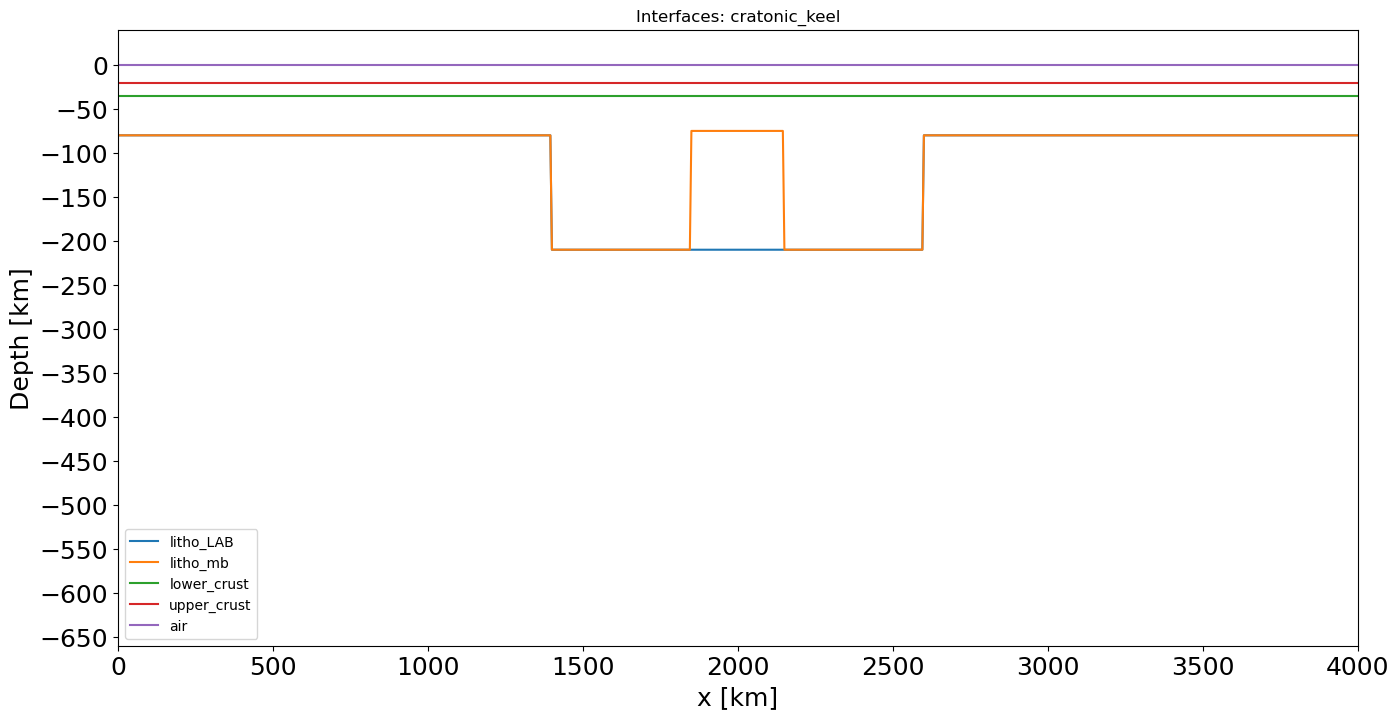

In [6]:
#Plot interfaces
fig, ax = plt.subplots(figsize=(16, 8))

for label, layer in interfaces.items():
    ax.plot(x / 1e3, (-layer + thickness_sa) / 1e3, label=f"{label}")

ax.set_yticks(np.arange(-Lz / 1e3, 1 / 1e3, 50))
ax.set_xlim([0, Lx/1000])
ax.set_ylim([(-Lz + thickness_sa) / 1e3, 0 + thickness_sa / 1e3])

ax.set_xlabel("x [km]")
ax.set_ylabel("Depth [km]")

ax.set_xlabel("x [km]", fontsize=label_size)
ax.set_ylabel("Depth [km]", fontsize=label_size)

plt.title("Interfaces: " + experiment)
plt.legend()

plt.show()

## Create initial temperature field

### `Preset` option as `False`

If the `preset == False`, the initial temperature structure is depth dependent and is 0°C at the surface and 1300°C at the base of the lithosphere at 130 km.
With these boundary conditions, the initial temperature structure in the interior of the lithosphere is given by the solution of the following equation:

$$ \kappa \frac{\partial^2 T(z)}{\partial z^2} + \frac{H(z)}{c_p} = 0$$

where $H(z)$ is the internal heat production of the different layers.

The sublithospheric temperature follows an adiabatic increase up to the bottom of the model:

$$T = T_p exp (g \alpha z ∕c_p) + \Delta T$$

Where $T_p$ is the potential temperature for the mantle, $g$ is the gravity aceletation, $\alpha$ is the volumetric expansion coefficient, $c_p$ is the specific heat capacity, $\Delta$ T is the increment in basal temperature.

For the experiments of LAB stability ou can increase the basal temperature by setting a value for `DeltaT`.

### `Preset` option as `True`
If the `preset == True` the temperature field is extracted from an external `scenario` and interpolated in the new grid accordind to the `interp_method` that can be setted bellow as:
- `'horizontal_mean'`: calculate the horizontal mean* for each depth of the external temperature field and interpolate in the new mesh using `interp1d` from `scipy`.<br>
    *If the external `scenario` is a `'stab_keel'`, you can set `keel_center == True` in Setup section above to select the cratonic region to calculate the horizontal mean.
- `'interp2d'`: interpolate the temperature field on the new grid using `interp2d` from `scipy` setting `interp_kind` as  `'linear'`, `'cubic'` or `'quintic'` as interpolation method.

You can handle with the temperature of the vertical boundaries by setting `bound` in the cell bellow as:
- `'mean'` (recommended): use the horizontal mean temperature of the external scenario interpolated in the new grid <br>
    or
- `'original'`: use the original boundary temperature from the external scenario interpolated in the new grid.

In [14]:
##############################################################################
# Initial temperature field
##############################################################################
 
print('Initial temperature field setup:')
scenario_infos.append('Initial temperature field setup:')

if(preset == False):
    T = 1300 * (z - thickness_sa) / (thickness_litho)  # Temperature
    # T = 1300 * (z - thickness_sa) / (130*1.0E3)  # Temperature of 1300 isotherm bellow the lithosphere

    ccapacity = 1250*1.0 #937.5=75% #J/kg/K? #DEFAULT.
    # ccapacity = 1250*0.75 #937.5=75% #J/kg/K?
    # ccapacity = 750
    print('Increase in mantle basal temperature (Ta): '+str(DeltaT)+' oC')
    scenario_infos.append('Increase in mantle basal temperature (Ta): '+str(DeltaT)+' oC')

    TP = 1262 #mantle potential temperature
    # TP = 1350
    # TP = 1400
    # TP = 1450
    print('Assumed mantle Potential Temperature: '+str(TP)+' oC')
    scenario_infos.append('Assumed mantle Potential Temperature: '+str(TP)+' oC')

    Ta = (TP / np.exp(-10 * 3.28e-5 * (z - thickness_sa) / ccapacity)) + DeltaT
    # Ta = 1262 / np.exp(-10 * 3.28e-5 * (z - thickness_sa) / ccapacity)steady s

    T[T < 0.0] = 0.0
    cond1 = Ta<T #VICTOR
    T[T > Ta] = Ta[T > Ta] #apply the temperature of asthenosphere Ta where temperature T is greater than Ta, 

    # kappa = 0.75*1.0e-6 #thermal diffusivity
    kappa = 1.0e-6 #thermal diffusivity

    H = np.zeros_like(T)

    cond = (z >= thickness_sa) & (z < thickness_upper_crust + thickness_sa)  # upper crust
    H[cond] = H_upper_crust

    cond = (z >= thickness_upper_crust + thickness_sa) & (
        z < thickness_lower_crust + thickness_upper_crust + thickness_sa
    )  # lower crust
    H[cond] = H_lower_crust

    Taux = np.copy(T)
    t = 0
    dt = 5000
    dt_sec = dt * 365 * 24 * 3600
    # cond = (z > thickness_sa + thickness_litho) | (T == 0)  # (T > 1300) | (T == 0) #OLD
    cond = cond1 | (T == 0)  # (T > 1300) | (T == 0) #VICTOR
    dz = Lz / (Nz - 1)
    
    while t < 500.0e6:
        T[1:-1] += (
            kappa * dt_sec * ((T[2:] + T[:-2] - 2 * T[1:-1]) / dz ** 2)
            + H[1:-1] * dt_sec / ccapacity
        )
        T[cond] = Taux[cond]
        t = t + dt
    
    T = np.ones_like(X) * T[:, None] #(Nz, Nx)

    print('shape T: ', np.shape(T))

    if(keel_adjust == True): #Making the base of cratonic keel cold as the base of the lithosphere (1300 oC)
        xcenter = Lx/2.0
    
        Datai = T

        Nx_aux = Nx
        Nz_aux = Nz
        Lx_aux = Lx
        Lz_aux = Lz

        x_aux = np.linspace(0, Lx_aux, Nx_aux)
        z_aux = np.linspace(Lz_aux, 0, Nz_aux)
        xx_aux, zz_aux  = np.meshgrid(x_aux, z_aux)
        
        datai_mean = calc_mean_temperaure_region(Datai, Nz_aux, xx_aux, 0, Lx_aux)

        #Making the temperature profile for the keel
        Tk_mean = np.copy(datai_mean)
        cond_mlit = (z_aux <= thickening+thickness_sa) & (z_aux >= thickness_sa + thickness_upper_crust + thickness_lower_crust)
                    
        T1 = datai_mean[cond_mlit][0] #bottom
        T0 = datai_mean[cond_mlit][-1] #top
        z1 = z_aux[cond_mlit][0]
        z0  = z_aux[cond_mlit][-1]

        # The temperature in the keel is linearly interpolated between the bottom and top of the keel
        Tk_mean[cond_mlit] = ((T1 - T0) / (z1 - z0)) * (z_aux[cond_mlit] - z0) + T0

        #interpolating the temperature field to the mesh of the model
        fk = interp1d(z_aux, Tk_mean)
        Tk_mean_interp = fk(z) #interpolated temperature profile for cratonic keel

        #dealing with <=0 values inherited from interpolation and setting to 0 values to the air layer
        Tk_mean_interp[Tk_mean_interp <= 1.0e-7] = 0.0 #dealing with <=0 values inherited from interpolation
        zcond = z <= 40.0e3
        Tk_mean_interp[zcond] = 0.0
    else:
        datai_mean = np.mean(T, axis=1) #simple horizontal mean for scenarios without cratonic keel

    for i in range(Nx): #Attributing the values of temperature field
        if(keel_adjust == True):
            if((x[i] >= xcenter - Lcraton/2.0 + shift_craton) & (x[i] <= xcenter + Lcraton/2.0 + shift_craton)): #keel region
                T.T[i, :] = Tk_mean_interp #must transpose to work

    # Save the initial temperature file
    # np.savetxt("input_temperature_0.txt", np.reshape(T, (Nx * Nz)), header="T1\nT2\nT3\nT4")

else:
    dz = Lz / (Nz - 1)

    print('Used external scenario: ', scenario)
    scenario_infos.append('Used external scenario: ' + scenario)

    from_dataset = True
    # from_dataset = False

    if(from_dataset == True):
        # print('entrei from dataset')
        # local = True
        local = False
        if(local==True):
            fpath = f"{machine_path}/{scenario}"
        else:
            # print('entrei local false')
            external_media = 'Joao_Macedo'
            # external_media = 'Joao_Macedo'
            if(path[1] == 'home'):
                fpath = f"{machine_path}/{external_media}{scenario}"
            elif(path[1] == 'Users'):
                fpath = f'/Volumes/{external_media}{scenario}'

            elif(path[1] == 'media'):
                fpath = f"{machine_path}/{external_media}{scenario}"
            elif(path[1] == 'Volumes'):
                fpath = f'/Volumes/{external_media}{scenario}'


        dataset = xr.open_dataset(f"{fpath}_output_temperature.nc")
        
        Nx_aux = int(dataset.nx)
        Nz_aux = int(dataset.nz)
        Lx_aux = float(dataset.lx)
        Lz_aux = float(dataset.lz)

        x_aux = np.linspace(0, Lx_aux, Nx_aux)
        z_aux = np.linspace(Lz_aux, 0, Nz_aux)
        xx_aux, zz_aux  = np.meshgrid(x_aux, z_aux)

        time = dataset.time[-1]
        Datai = dataset.temperature[-1].values.T
    else:
        fpath = f"{machine_path}/Doutorado/cenarios/mandyoc/{scenario}/"
        Nx_aux, Nz_aux, Lx_aux, Lz_aux = read_params(fpath)

        x_aux = np.linspace(0, Lx_aux, Nx_aux)
        z_aux = np.linspace(Lz_aux, 0, Nz_aux)
        xx_aux, zz_aux  = np.meshgrid(x_aux, z_aux)

        steps = sorted(glob.glob(fpath+"time_*.txt"), key=os.path.getmtime)
        step_final = int(steps[-1].split('/')[-1][5:-4]) #step of final thermal structure
        
        time_fname = fpath + 'time_' + str(step_final) + '.txt'
        time = np.loadtxt(time_fname, usecols=2, max_rows=1)

        Datai = read_data('temperature', step_final, Nz_aux, Nx_aux, fpath) #(read final thermal structure (Nz, Nx)
    

    #Setting procedure with external temperature field. Choose between:
        ##Use the horizontal mean of temperature from final step of used scenario (horizontal_mean)

    interp_method = 'horizontal_mean' #using interp1d
    
    print(f'Interpolation of temperature field using: {interp_method}')
    scenario_infos.append(f'Interpolation of temperature field using: {interp_method}')
    
    if(interp_method == 'horizontal_mean'):
        if(keel_adjust == True): #Making the base of cratonic keel cold as the base of the lithosphere (1300 oC)
            xcenter = Lx/2.0

            datai_mean = calc_mean_temperaure_region(Datai, Nz_aux, xx_aux, 0, Lx_aux)

            #Making the temperature profile for the keel
            Tk_mean = np.copy(datai_mean)
            cond_mlit = (z_aux <= thickening+thickness_sa) & (z_aux >= thickness_sa + thickness_upper_crust + thickness_lower_crust)
                     
            T1 = datai_mean[cond_mlit][0] #bottom
            T0 = datai_mean[cond_mlit][-1] #top
            z1 = z_aux[cond_mlit][0]
            z0  = z_aux[cond_mlit][-1]

            # The temperature in the keel is linearly interpolated between the bottom and top of the keel
            Tk_mean[cond_mlit] = ((T1 - T0) / (z1 - z0)) * (z_aux[cond_mlit] - z0) + T0

            #interpolating the temperature field to the mesh of the model
            fk = interp1d(z_aux, Tk_mean)
            Tk_mean_interp = fk(z) #interpolated temperature profile for cratonic keel

            #dealing with <=0 values inherited from interpolation and setting to 0 values to the air layer
            Tk_mean_interp[Tk_mean_interp <= 1.0e-7] = 0.0 #dealing with <=0 values inherited from interpolation
            zcond = z <= 40.0e3
            Tk_mean_interp[zcond] = 0.0

        else:
            datai_mean = np.mean(Datai, axis=1) #simple horizontal mean for scenarios without cratonic keel

        f = interp1d(z_aux, datai_mean) #funcion to interpolate the temperature field
        datai_mean_interp = f(z) #applying the function to obtain the temperature field to the new mesh

        zcond = z <= 40.0e3
        datai_mean_interp[datai_mean_interp <= 1.0e-7] = 0.0 #dealing with <=0 values inherited from interpolation
        datai_mean_interp[zcond] = 0.0

        T = np.zeros((Nx, Nz)) #(Nx, Nz) = transpose of original shape (Nz, Nx)
        
        for i in range(Nx): #Attributing the values of temperature field
            if(keel_adjust == True):
                if((x[i] >= xcenter - Lcraton/2.0 + shift_craton) & (x[i] <= xcenter + Lcraton/2.0 + shift_craton)): #keel region
                    T[i, :] = Tk_mean_interp
                else:
                    T[i, :] = datai_mean_interp
            else:
                T[i, :] = datai_mean_interp

        T = T.T #(Nz,Nx): transpose T to plot below
        print('shape T: ', np.shape(T))

    # np.savetxt("input_temperature_0.txt", np.reshape(T, (Nx * Nz)), header="T1\nT2\nT3\nT4")


Initial temperature field setup:
Increase in mantle basal temperature (Ta): 0 oC
Assumed mantle Potential Temperature: 1262 oC
shape T:  (141, 801)


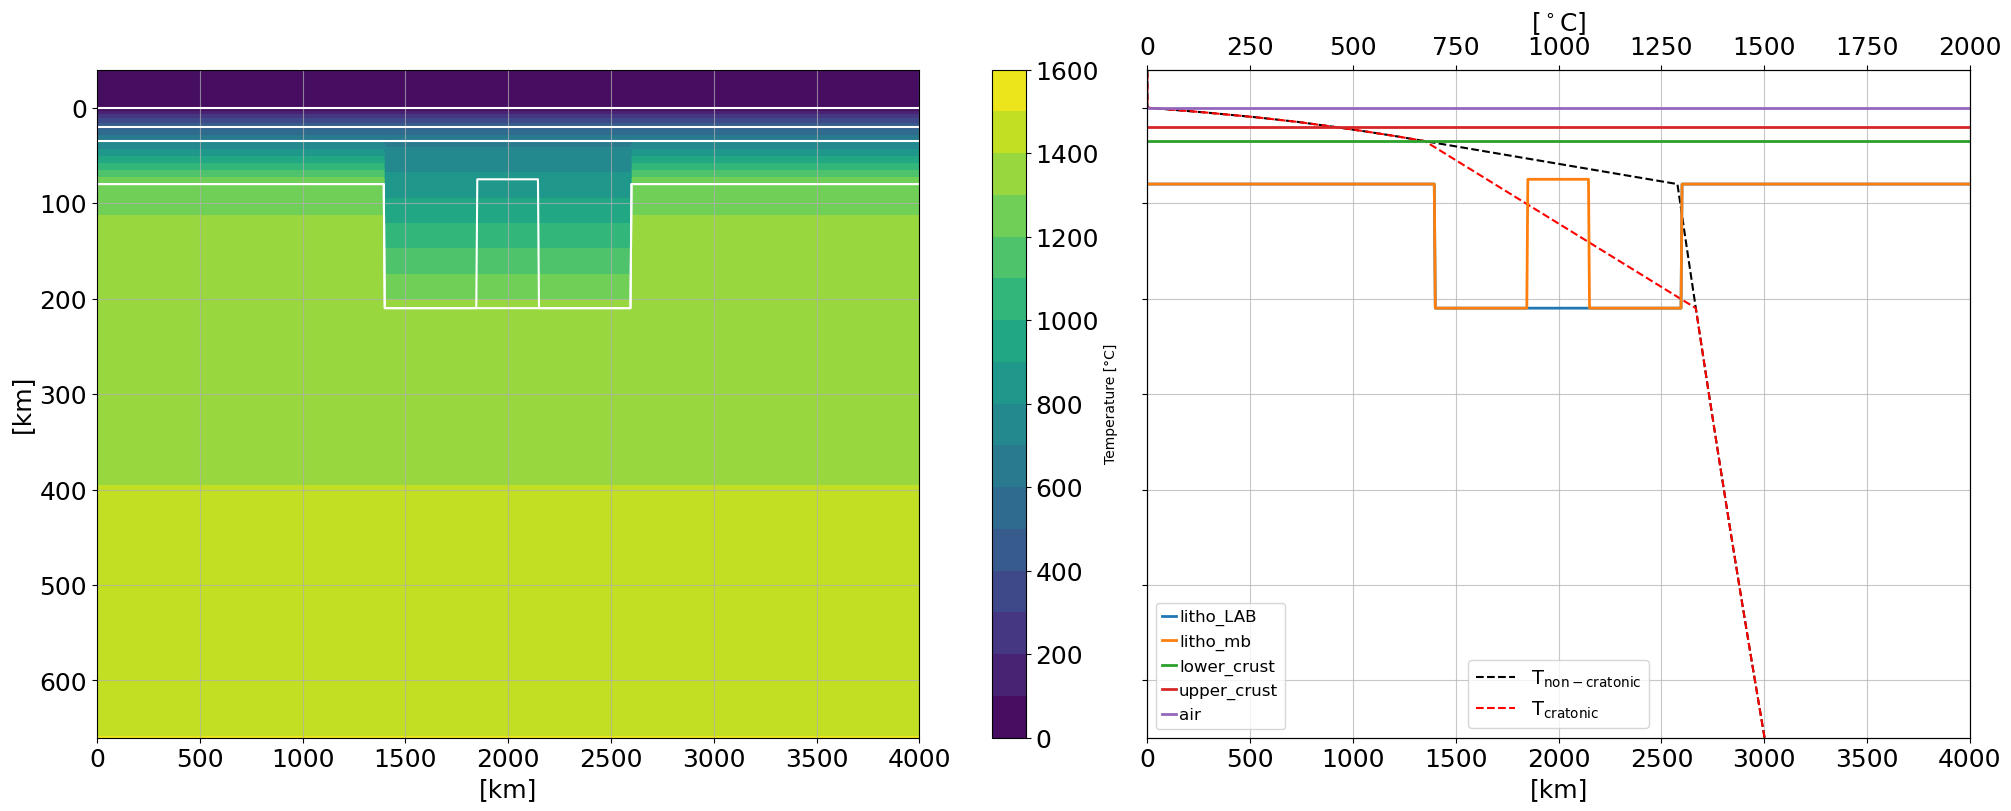

In [15]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(20, 8), sharey=True)

im = ax0.contourf(X / 1.0e3, (Z - thickness_sa) / 1.0e3, T,
                  levels=np.arange(0, np.max(T) + 100, 100))
ax0.set_ylim((Lz - thickness_sa) / 1.0e3, -thickness_sa / 1000)
ax0.set_xlabel("km", fontsize=label_size)
ax0.set_ylabel("km", fontsize=label_size)
ax1.set_xlabel("$^\circ$C", fontsize=label_size)


if(keel_adjust==True):    
    idx = 0

    ax1.plot(T[:, idx], (z - thickness_sa) / 1.0e3, "--k", label=r'T$_{\mathrm{non-cratonic}}$')
    ax1.plot(Tk_mean_interp, (z - thickness_sa) / 1.0e3, '--', color='r', label=r'T$_{\mathrm{cratonic}}$')
    
    # ax1.plot(tfit, (z - thickness_sa) / 1.0e3, '--', color='b', label=r'T$_{\mathrm{fit}}$')
else:
    ax1.plot(T[:, 0], (z - thickness_sa) / 1.0e3, "--k", label=r'T$_{\mathrm{mean}}$')

T_xlim = 2000 #oC
code = 0

ax_aux = ax1.twiny()

for label, layer in interfaces.items():
    # print(label, "(size): ", np.size(layer))
    # ax1.plot(x/1.0E3, (-layer + thickness_sa)/1.0E3, label=f"{label}")
    ax0.plot(x/1.0E3, (layer - thickness_sa)/1.0E3, color='xkcd:white')
    ax_aux.plot(x/1.0E3, (layer - thickness_sa)/1.0E3, label=label, lw=2)


ax0.set_ylim((Lz - thickness_sa) / 1.0e3, -thickness_sa / 1000)
ax0.set_xlabel("[km]", fontsize=label_size)
ax0.set_ylabel("[km]", fontsize=label_size)


ax1.set_xlabel("[$^\circ$C]", fontsize=label_size)
cbar = fig.colorbar(im, orientation='vertical', ax=ax0)
cbar.set_label("Temperature [°C]")

ax1.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax1.xaxis.set_label_position('top')
ax1.set_ylim((Lz - thickness_sa) / 1.0e3, -thickness_sa / 1000)
ax1.set_xlim(0, T_xlim)
ax0.grid(':k', alpha=0.7)
ax1.grid(':k', alpha=0.7)

ax_aux.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
ax_aux.xaxis.set_label_position('bottom')
ax_aux.set_xlabel('[km]', fontsize=label_size)
ax_aux.set_xlim(0, Lx/1000)
ax_aux.set_ylim((Lz - thickness_sa) / 1.0e3, -thickness_sa / 1000)

ax1.legend(loc='lower center', fontsize=14, ncol=1)
ax_aux.legend(loc='lower left', fontsize=12, ncol=1, handletextpad=0.2, handlelength=.8)

# plt.savefig("initial_temperature_field.png")
# plt.close()


### Boundary condition - Velocity

The horizontal velocity field along the left and right borders of the domain presents two layers:
* Constant velocity with depth at $0 ≤ z < h_c$
* Linearly variable velocity with depth at $h_c ≤ z ≤ h_c + h_a$

where $h_c = 150$ km is the thickness of the upper layer with constant velocity, corresponding to the lithosphere $h_{litho} = 130$ km and part of the asthenosphere, and $h_a = 110$ km corresponds to the remaining asthenospheric portion of the model until the bottom
of the model, where the horizontal velocity at the borders of the model varies linearly with depth.
Therefore, the sum $h_c + h_a$ represents the total thickness of the model without the “sticky air” layer.

In [26]:
velocity = 1.0 #cm/yr

# Convert cm to m and also divide by 2
velocity = velocity / (100.0 * 2.0) #m/yr

# Convert m/yr to m/s:
velocity_L = velocity / (365 * 24 * 3600)

# Convert cm/year to m/s:
# velocity_L = 0.005 / (365 * 24 * 3600) #original

# Define the thickness with constant velocity in meters
thickness_v_const = 150.0e3

thickness_a = Lz - thickness_sa - thickness_v_const

velocity_R = 2 * velocity_L * (thickness_v_const + thickness_a) / thickness_a

fac_air = 10.0e3

In [27]:
# Create  horizontal and vertical velocity:
VX, VZ = np.zeros_like(X), np.zeros_like(X)

Velocity for the left side (`x == 0`):

In [28]:
# When 0 <= z <= (h_v_const + thickness_sa), VX is zero.
# When (h_v_const * thickness_sa) <= z <= Lz, VX goes from 0 to vR.
cond = (Z > thickness_v_const + thickness_sa) & (X == 0)
VX[cond] = velocity_R * (Z[cond] - thickness_v_const - thickness_sa) / thickness_a

Velocity for the right side (`x == Lx`):

In [29]:
# When 0 <= z <= (h_v_const + thickness_sa), VX is 2vL
# When (h_v_const + thickness_sa) < z <= Lz, VX goes from 2vL to -vR + 2vL
cond = (Z > thickness_v_const + thickness_sa) & (X == Lx)
VX[cond] = -velocity_R * (Z[cond] - thickness_v_const - thickness_sa) / thickness_a

VX[X == Lx] += 2 * velocity_L

VX[Z <= thickness_sa - fac_air] = 0

Due to the mass conservation is assumed, the sum of the integrals over the boundaries (material flow) must be zero.

In [30]:
# For the left side:
v0= VX[(X == 0)]
sum_velocity_left = np.sum(v0[1:-1]) + (v0[0] + v0[-1]) / 2.0

# For the right side:
vf = VX[(X == Lx)]
sum_velocity_right = np.sum(vf[1:-1]) + (vf[0] + vf[-1]) / 2.0

dz = Lz / (Nz - 1)
diff = (sum_velocity_right - sum_velocity_left) * dz

print("Sum of the integrals over the boundary is:", diff)

Sum of the integrals over the boundary is: 2.8538812785388226e-06


If the sum of the integrals over the boundaries is not zero, because rounding errors, we add a very small flow on the top to compensate this difference.
In fact this is a very small correction.

In [31]:
vv = -diff / Lx

VZ[Z == 0] = vv

Create and save the initial velocity file:

In [32]:
VVX = np.copy(np.reshape(VX, Nx * Nz))
VVZ = np.copy(np.reshape(VZ, Nx * Nz))

velocity = np.zeros((2, Nx * Nz))

velocity[0, :] = VVX
velocity[1, :] = VVZ

velocity = np.reshape(velocity.T, (np.size(velocity)))

np.savetxt("input_velocity_0.txt", velocity, header="v1\nv2\nv3\nv4")

For Wilson cycle experiments we need to change reescale the velocity field to simulate convergent process by setting `variable_bcv == True` in Step section above to create a `scale_bcv.txt` file specifying:
- Number of instants that velocity fild must be reescaled
- Time_instant_in_Myr scale_factor_of_velocity_field

In [33]:
if(variable_bcv == True):
        var_bcv = f""" 1
        30.0 -1.0

        """
        # var_bcv = f""" 2
        # 50.0 -1.0
        # 150  -1.0E-15
        # """
        # Create the parameter file
        with open("scale_bcv.txt", "w") as f:
            for line in var_bcv.split("\n"):
                line = line.strip()
                if len(line):
                    f.write(" ".join(line.split()) + "\n")

Plot the velocity profile for the boundaries:

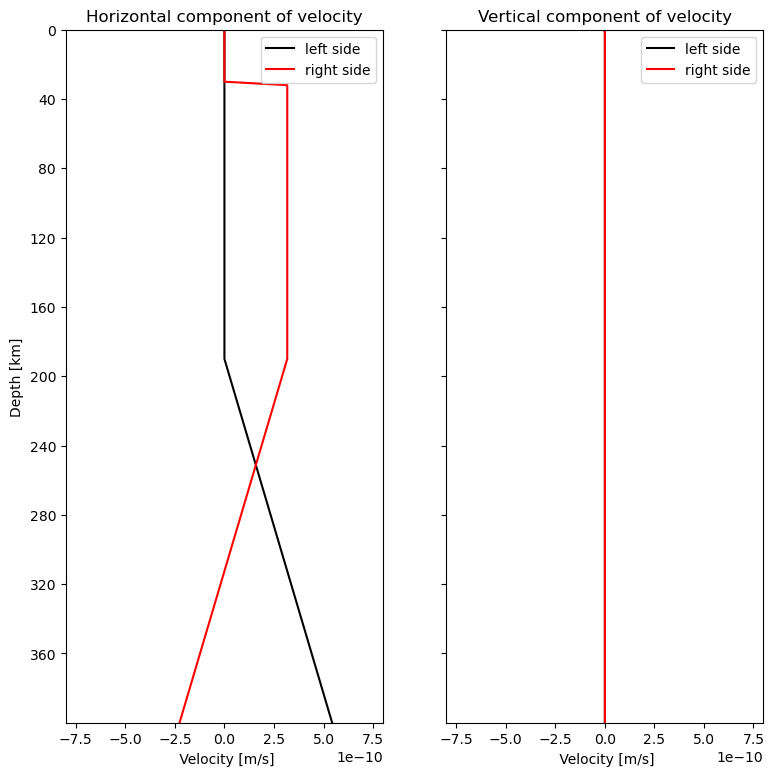

In [34]:
plt.close()
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(9, 9), sharey=True)

ax0.plot(VX[:, 0], (z) / 1e3, "k-", label="left side")
ax1.plot(VZ[:, 0], (z) / 1e3, "k-", label="left side")

ax0.plot(VX[:, -1], (z ) / 1e3, "r-", label="right side")
ax1.plot(VZ[:, -1], (z) / 1e3, "r-", label="right side")

ax0.legend()
ax1.legend()

ax0_xlim = ax0.get_xlim()
ax1_xlim = ax1.get_xlim()

ax0.set_yticks(np.arange(-40, Lz / 1e3, 40))
#ax1.set_yticks(np.arange(0, Lz / 1000, 20))

ax0.set_ylim([Lz / 1e3 , 0])


ax0.set_xlim([-8e-10, 8e-10])
ax1.set_xlim([-8e-10, 8e-10])

ax0.set_xlabel(" Velocity [m/s]")
ax1.set_xlabel(" Velocity [m/s]")
ax0.set_ylabel("Depth [km]")

ax0.set_title("Horizontal component of velocity")
ax1.set_title("Vertical component of velocity")

plt.show()

# Surface process

Setting `sp_surface_processes == True` and `sp_surface_processes == True` in Step section above creates a `precipitation.txt` file. The procedure is the same adopted by Silva and Sacek (2022):

$$\dot e(x) = k_{\mathrm{sp}} e_f(x)\mathrm{\ \ for \ }t>10\mathrm{\ Myr,}$$

where, $k_{\mathrm{sp}}$ is the maximum denudation rate and $e_f$ is the spatial control of denudation, given by:


$$e_f(x) = \mathrm{exp}\left[-\frac{(x - x_c)^6}{x_{\sigma}^6}\right]\mathrm{.}$$

$x_{\sigma}$ controls the spatial extent of denudation from the center of the model at position $x = x_c$, and $t$ is time since the onset of the numerical simulation. Erosion acts only if the topographic surface is above sea level ($h > h_{\mathrm{sl}}$).

Setting `climate_change_from_ascii == True` in Step section above you can choose the instants to the action the surface process and the scale factor of the precipitation function by modifying `climate` as:

`climate = f'''
     N_instants
     instant_0 scale_0
     ...
     instant_i scale_i
     ...
     instant_N scale_N
 '''`
 
where:
- `N_instant `: Number of instants that surface process must be reescaled
- `instant_ `: Time instant in Myr scale factor of surface process
- `scale_i`: scale factor of surface process



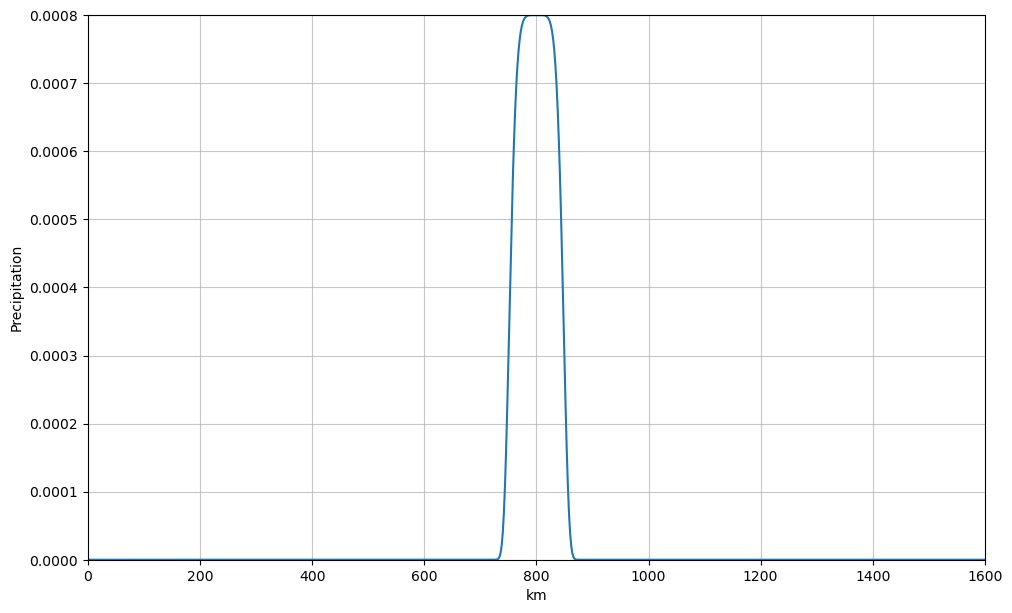

In [35]:
sp_surface_processes = True
climate_change_from_ascii = True
precipitation_profile_from_ascii = True

if(sp_surface_processes == True):
    if(climate_change_from_ascii == True):
        #When climate effects will start to act - scaling to 1
        climate = f'''
                2
                0 0.0
                10 0.02
            '''

        with open('climate.txt', 'w') as f:
            for line in climate.split('\n'):
                line = line.strip()
                if len(line):
                    f.write(' '.join(line.split()) + '\n')

    if(precipitation_profile_from_ascii ==True):
        #Creating precipitation profile

        # prec = 0.0008*np.exp(-(x-Lx/2)**6/(Lx/8)**6) #original
        # prec = 0.0008*np.exp(-(x-Lx/2)**6/(Lx/(8*2))**6) #100 km
        prec = 0.0008*np.exp(-(x-Lx/2)**6/(Lx/(8*4))**6) #50 km
        np.savetxt("precipitation.txt", prec, fmt="%.8f")
        
        plt.close()
        plt.figure(figsize=(10, 6), constrained_layout=True)
        plt.xlim([0, Lx/1.0E3])
        plt.ylim([0, np.max(prec)])
        plt.xlabel("km")
        plt.ylabel("Precipitation")
        plt.plot(x/1000,prec)
        plt.grid(':k', alpha=0.7)

        figname='precipitation_profile.png'
        plt.savefig(figname, dpi=300)
        plt.show()

### Create the parameter file

In [36]:
params = f"""
nx = {Nx}
nz = {Nz}
lx = {Lx}
lz = {Lz}


# Simulation options
multigrid                           = 1             # ok -> soon to be on the command line only
solver                              = direct        # default is direct [direct/iterative]
denok                               = {denok}       # default is 1.0E-4
particles_per_element               = {particles_per_element}          # default is 81
particles_perturb_factor            = 0.7           # default is 0.5 [values are between 0 and 1]
rtol                                = 1.0e-7        # the absolute size of the residual norm (relevant only for iterative methods), default is 1.0E-5
RK4                                 = Euler         # default is Euler [Euler/Runge-Kutta]
Xi_min                              = 1.0e-7       # default is 1.0E-14
random_initial_strain               = 0.3           # default is 0.0
pressure_const                      = -1.0          # default is -1.0 (not used) - useful only in horizontal 2D models
initial_dynamic_range               = True         # default is False [True/False]
periodic_boundary                   = {periodic_boundary}         # default is False [True/False]
high_kappa_in_asthenosphere         = {high_kappa_in_asthenosphere}         # default is False [True/False]
K_fluvial                           = 2.0e-7        # default is 2.0E-7
m_fluvial                           = 1.0           # default is 1.0
sea_level                           = 0.0           # default is 0.0
basal_heat                          = 0.0          # default is -1.0

# Surface processes
sp_surface_tracking                 = {sp_surface_tracking}         # default is False [True/False]
sp_surface_processes                = {sp_surface_processes}         # default is False [True/False]
sp_dt                               = 1.0e5        # default is 0.0
sp_d_c                              = 1.0          # default is 0.0
plot_sediment                       = False         # default is False [True/False]
a2l                                 = True          # default is True [True/False]

free_surface_stab                   = True          # default is True [True/False]
theta_FSSA                          = 0.5           # default is 0.5 (only relevant when free_surface_stab = True)

# Time constrains
step_max                            = 5000          # Maximum time-step of the simulation
time_max                            = {time_max}     # Maximum time of the simulation [years]
dt_max                              = 10.0e3      # Maximum time between steps of the simulation [years]
step_print                          = {step_print}            # Make file every <step_print>
sub_division_time_step              = 0.5           # default is 1.0
initial_print_step                  = 0             # default is 0
initial_print_max_time              = 1.0e6         # default is 1.0E6 [years]

# Viscosity
viscosity_reference                 = 1.0e26        # Reference viscosity [Pa.s]
viscosity_max                       = 1.0e25        # Maximum viscosity [Pa.s]
viscosity_min                       = 1.0e18        # Minimum viscosity [Pa.s]
viscosity_per_element               = constant      # default is variable [constant/variable]
viscosity_mean_method               = arithmetic      # default is harmonic [harmonic/arithmetic]
viscosity_dependence                = pressure      # default is depth [pressure/depth]

# External ASCII inputs/outputs
interfaces_from_ascii               = True          # default is False [True/False]
n_interfaces                        = {len(interfaces.keys())}           # Number of interfaces int the interfaces.txt file
variable_bcv                        = {variable_bcv}         # default is False [True/False]
temperature_from_ascii              = True         # default is False [True/False]
velocity_from_ascii                 = {velocity_from_ascii}         # default is False [True/False]
binary_output                       = False         # default is False [True/False]
sticky_blanket_air                  = True         # default is False [True/False]
precipitation_profile_from_ascii    = {precipitation_profile_from_ascii}         # default is False [True/False]
climate_change_from_ascii           = {climate_change_from_ascii}         # default is False [True/False]


print_step_files                    = {print_step_files}          # default is True [True/False]
checkered                           = False         # Print one element in the print_step_files (default is False [True/False])

sp_mode                             = 5             # default is 1 [0/1/2]

geoq                                = on            # ok
geoq_fac                            = 100.0           # ok

# Physical parameters
temperature_difference              = 1500.         # ok
thermal_expansion_coefficient       = 3.28e-5       # ok
thermal_diffusivity_coefficient     = 1.0e-6        # ok
gravity_acceleration                = 10.0          # ok
density_mantle                      = 3300.         # ok
external_heat                       = 0.0e-12       # ok
heat_capacity                       = 1250.         # ok

non_linear_method                   = on            # ok
adiabatic_component                 = on            # ok
radiogenic_component                = on            # ok

# Velocity boundary conditions
top_normal_velocity                 = fixed         # ok
top_tangential_velocity             = free          # ok
bot_normal_velocity                 = fixed         # ok
bot_tangential_velocity             = free          # ok
left_normal_velocity                = {left_normal_velocity}         # ok
left_tangential_velocity            = {left_tangential_velocity}         # ok
right_normal_velocity               = {right_normal_velocity}         # ok
right_tangential_velocity           = {right_tangential_velocity}         # ok

surface_velocity                    = 0.0e-2        # ok
multi_velocity                      = False         # default is False [True/False]

# Temperature boundary conditions
top_temperature                     = {top_temperature}         # ok
bot_temperature                     = {bot_temperature}         # ok
left_temperature                    = {bot_temperature}          # ok
right_temperature                   = {bot_temperature}         # ok

rheology_model                      = 9             # ok
T_initial                           = 3             # ok

"""
# Create the parameter file
with open("param.txt", "w") as f:
    for line in params.split("\n"):
        line = line.strip()
        if len(line):
            f.write(" ".join(line.split()) + "\n")

# Creating a file containing the scenario's main characteristics

In [37]:
np.savetxt('infos_' + experiment + '.txt', scenario_infos, fmt="%s")

## Run the model 

In this example, mandyoc use the following flags: 

* -seed 0,2
* -strain_seed 0.0,1.0 

You can run the model as:

```
mpirun -n NUMBER_OF_CORES mandyoc -seed 0,2 -strain_seed 0.0,1.0 
```

*You have to change NUMBER_OF_CORES.*

Run the cell bellow to create a shell script that to run this example

In [38]:
NUMBER_OF_CORES = 4
run = f'''
        #!/bin/bash
        mpirun -n {NUMBER_OF_CORES} mandyoc -seed 0,2 -strain_seed 0.0,1.0
       '''

with open('run.sh', 'w') as f:
    for line in run.split('\n'):
        line = line.strip()
        if len(line):
            f.write(' '.join(line.split()) + '\n')

In [39]:
scenario_infos

['SCENARIO INFOS:',
 ' ',
 'Type of experiment: Rifting experiment',
 ' ',
 'Viscosity scale factors (C):',
 'C asthenosphere: 1.0',
 'C mantle lithosphere: 10.0',
 'C seed: 1.0',
 'C lower crust: 1.0',
 'C upper crust: 1.0',
 'C air: 1.0',
 ' ',
 'Preset of initial temperature field: False',
 'Increase in mantle basal temperature (Ta): 0 oC',
 'Seed extra fragil: False',
 'Use horizontal mean of temperature from preset in lithosphere: False',
 'High kappa in asthenosphere: False',
 'Surface process: False',
 'Climate change: False',
 'Velocity field: True',
 ' ',
 'Domain parameters:',
 'Lx: 1600.0 km',
 'Lz: 400.0 km',
 'Nx: 801',
 'Nz: 201',
 'Resolution dx x dz: 2x2 km2',
 ' ',
 'Layers thickness:',
 'Air: 40.0 km',
 'Upper crust: 20.0 km',
 'Lower crust: 15.0 km',
 'Lithospheric Mantle: 45.0 km',
 'Lithosphere: 80.0 km',
 ' ',
 'Initial temperature field setup:',
 'Increase in mantle basal temperature (Ta): 0 oC',
 'Assumed mantle Potential Temperature: 1262 oC']